In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.modeling.models import Sersic2D
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_id_2d import Gen_multibeams, Gen_temp_dict, args
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism
from astropy.wcs import wcs

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
buldge_cat = Table.read(fits.open('../dataframes/galaxy_frames/goods_bulge.fits'), format = 'fits').to_pandas()

In [4]:
buldge_cat.keys()

Index(['idx', 'candels_id', 'ra', 'dec', 'field', 'Hmag', 'UV_col', 'z',
       'z_type', 'z_phot', 'logMstar', 'logSFR', 'sfr_type', 'logLx', 'cntR',
       'spec_type', 'f_sph', 'f_disk', 'f_irr', 'f_pt', 'f_unc',
       'logSFR_100um', 'logSFR_160um', 'logSFR_SED', 'logSFR_250um',
       'logSFR_350um', 'logSFR_500um', 'flux_radio', 'Lnu_2700A',
       'cnts_0p5to7', 'cnts_0p5to2', 'cnts_2to7', 'stack_flux_100um',
       'stack_flux_160um', 'stack_cov_100um', 'stack_cov_160um', 'flux_100um',
       'flux_160um', 'flux_250um', 'flux_350um', 'flux_500um'],
      dtype='object')

In [63]:
def find_cand_id(gal_ra, gal_dec, cat_ra, cat_dec, cat_id, galid):
    r = (1. / 60 / 60) * 0.05
    for i in range(len(gal_ra)):
        cosr = np.sin(np.radians(gal_dec[i])) * np.sin(np.radians(cat_dec)) + np.cos(np.radians(gal_dec[i]))\
                * np.cos(np.radians(cat_dec)) * np.cos(np.radians(gal_ra[i]) - np.radians(cat_ra))
        rad = np.arccos(cosr)
        rad = np.degrees(rad)
        for ii in range(len(rad)):
            if rad[ii] < r:
                galid[i] = cat_id[ii]
    return galid

# create catalog

In [17]:
inouts = np.repeat(-99.0, len(buldge_cat.ra))

for fld in glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/*'):

    incat = Table.read(fits.open(fld), format = 'fits').to_pandas()
    inouts = find_cand_id(buldge_cat.ra.values,  buldge_cat.dec.values,incat.RA.values,incat.DEC.values, incat.ID.values, inouts)

In [19]:
buldge_cat['threeDHST_id'] = np.array(inouts).astype(int)

In [20]:
len(buldge_cat.query('threeDHST_id > 0'))

256

In [21]:
all_obj = buldge_cat.query('threeDHST_id > 0')

In [2]:
v4N = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Eazy/goodsn_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()
v4S = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),
                 format='fits').to_pandas()

v4Ncat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodsn_3dhst.v4.4.cats/Catalog/goodsn_3dhst.v4.4.cat',
                 format='ascii').to_pandas()
v4Scat = Table.read('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Catalog/goodss_3dhst.v4.4.cat',
                 format='ascii').to_pandas()

v4N['use'] = v4Ncat['use_phot']
v4S['use'] = v4Scat['use_phot']

v4N['star'] = v4Ncat['class_star']
v4S['star'] = v4Scat['class_star']

v4N['f125'] = v4Ncat['f_F125W']
v4S['f125'] = v4Scat['f_F125W']

v4N['f160'] = v4Ncat['f_F160W']
v4S['f160'] = v4Scat['f_F160W']

In [36]:
inout = np.repeat(0, len(v4S))
for i in v4S.index:
    if v4S.id[i] in all_obj.query('field == 1').threeDHST_id.values:
        inout[i] = 1
v4S['inout'] = inout

inout = np.repeat(0, len(v4N))
for i in v4N.index:
    if v4N.id[i] in all_obj.query('field == 2').threeDHST_id.values:
        inout[i] = 1
v4N['inout'] = inout

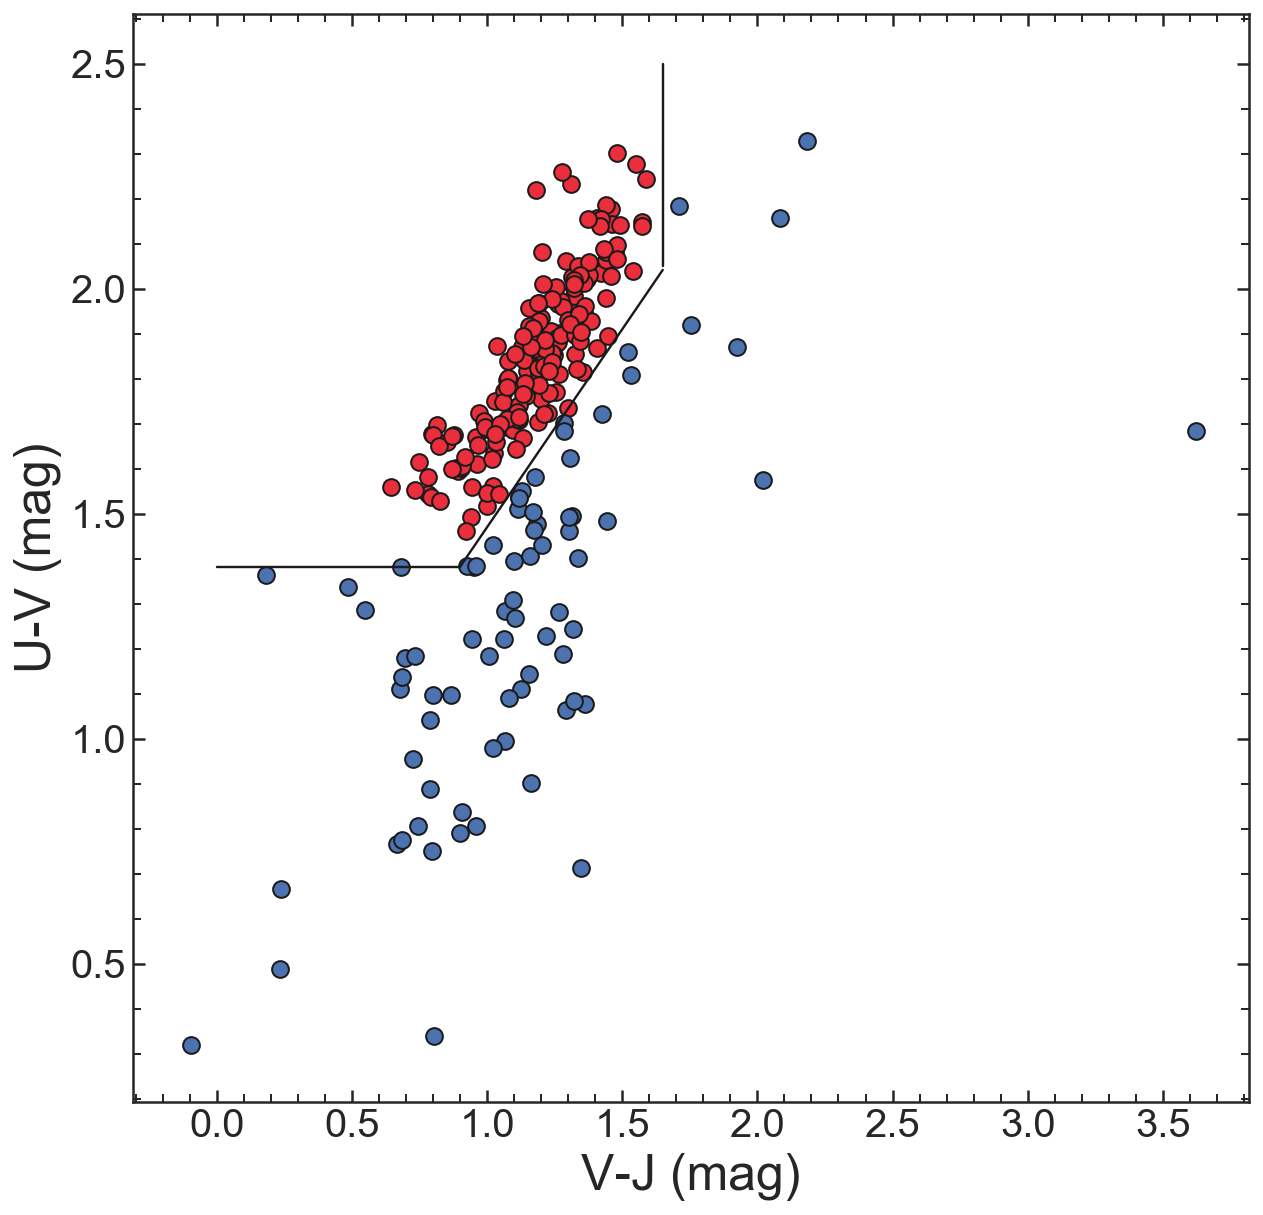

In [58]:
# v4N_samp = v4N.query('use == 1 and star < 0.8 and inout > 0')
# v4S_samp = v4S.query('use == 1 and star < 0.8 and inout > 0')

v4N_samp = v4N.query('inout > 0')
v4S_samp = v4S.query('inout > 0')

def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

NUV_s = Color(v4N_samp.restU, v4N_samp.restV)
NVJ_s = Color(v4N_samp.restV, v4N_samp.restJ)
SUV_s = Color(v4S_samp.restU, v4S_samp.restV)
SVJ_s = Color(v4S_samp.restV, v4S_samp.restJ)

SQ_s = []
NQ_s = []
Ssf_s = []
Nsf_s = []
for i in NUV_s.index:
    if NUV_s[i]>=0.88*NVJ_s[i]+0.59 and NUV_s[i]>1.382 and NVJ_s[i]<1.65:
        NQ_s.append(i)
    else:
        Nsf_s.append(i)
    
for i in SUV_s.index:
    if SUV_s[i]>=0.88*SVJ_s[i]+0.59 and SUV_s[i]>1.382 and SVJ_s[i]<1.65 and i != 48719: 
        SQ_s.append(i)
    else:
        Ssf_s.append(i)
               
plt.figure(figsize=[10,10])

plt.scatter(SVJ_s[SQ_s], SUV_s[SQ_s],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')
plt.scatter(NVJ_s[NQ_s], NUV_s[NQ_s],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')

plt.scatter(SVJ_s[Ssf_s], SUV_s[Ssf_s],marker = 'o', s=70, color = 'b',linewidths=1, edgecolors='k')
plt.scatter(NVJ_s[Nsf_s], NUV_s[Nsf_s],marker = 'o', s=70, color = 'b',linewidths=1, edgecolors='k')


plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
# plt.axis([0,2.5,.5,2.5])

plt.xlabel('V-J (mag)', fontsize=25)
plt.ylabel('U-V (mag)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


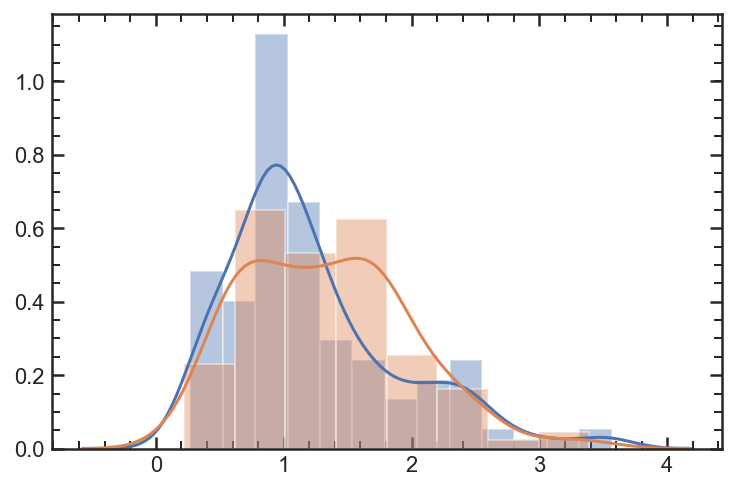

In [54]:
sea.distplot(v4N_samp.z500.values)
sea.distplot(v4S_samp.z500.values)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


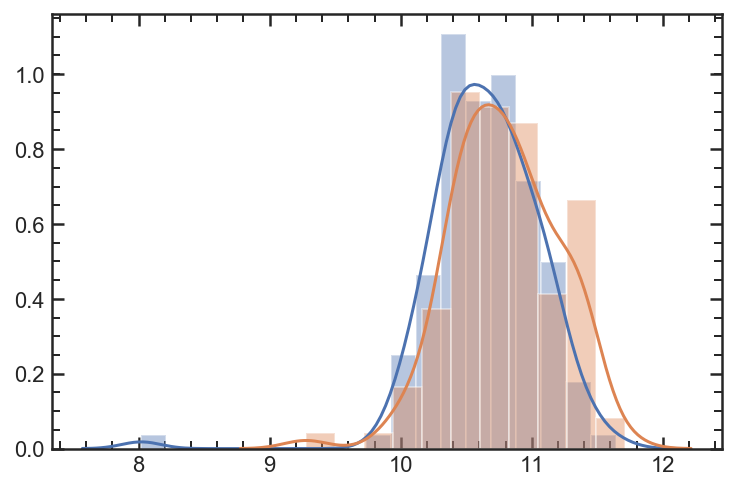

In [55]:
sea.distplot(np.log10(v4N_samp.mass.values))
sea.distplot(np.log10(v4S_samp.mass.values))

In [61]:
GS_buldge = pd.DataFrame({ 'id' : v4S_samp.id.values , 'ra' : v4S_samp.ra.values, 'dec' : v4S_samp.dec.values, 'zphot' : v4S_samp.z500.values
                       , 'f125': v4S_samp.f125.values, 'f160': v4S_samp.f160.values, 'mass' : v4S_samp.mass.values,
                      'zerr' : (v4S_samp.z840.values - v4S_samp.z160.values) / (1 + v4S_samp.z500.values) / 2,
                         'use' : v4S_samp.use.values, 'star' : v4S_samp.star.values})
GN_buldge = pd.DataFrame({ 'id' : v4N_samp.id.values , 'ra' : v4N_samp.ra.values, 'dec' : v4N_samp.dec.values, 'zphot' : v4N_samp.z500.values
                       , 'f125': v4N_samp.f125.values, 'f160': v4N_samp.f160.values, 'mass' : v4N_samp.mass.values,
                      'zerr' : (v4N_samp.z840.values - v4N_samp.z160.values) / (1 + v4N_samp.z500.values) / 2,
                         'use' : v4N_samp.use.values, 'star' : v4N_samp.star.values})

In [62]:
GS_buldge.to_pickle('../dataframes/galaxy_frames/GS_buldge.pkl')
GN_buldge.to_pickle('../dataframes/galaxy_frames/GN_buldge.pkl')

In [64]:
mdb = pd.read_pickle('../dataframes/fitdb/fullfitdb.pkl')
SFdb = pd.read_pickle('../Casey_data/SF_db_p1.pkl')

In [102]:
from spec_extract import Stack

def Extract_g102(field, galaxy):
    if field[1] == 'N':
        pre = 'N'
    else:
        pre = 'S'
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*.1D.fits'.format(pre, galaxy))

    Bwv, Bfl, Ber, Bft, Bln, Bct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])
        print(spec_list[i])
        try:
            Bwv.append(np.array(dat['G102'].data['wave']).T)
            Bfl.append(np.array(dat['G102'].data['flux']).T)
            Ber.append(np.array(dat['G102'].data['err']).T)
            Bft.append(np.array(dat['G102'].data['flat']).T)
            Bln.append(np.array(dat['G102'].data['line']).T)
            Bct.append(np.array(dat['G102'].data['cont']).T)

        except:
            print('no g102')

    if len(Bwv) > 0:                
        return Stack(Bwv, Bfl, Ber, Bft, Bln, Bct)

def Extract_g141(field, galaxy):
    if field[1] == 'N':
        pre = 'N'
    else:
        pre = 'S'
    spec_list = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*{0}*/*{1}*.1D.fits'.format(pre, galaxy))

    Rwv, Rfl, Rer, Rft, Rln, Rct = [[],[],[],[],[],[]]

    for i in range(len(spec_list)):
        dat = fits.open(spec_list[i])

        try:
            Rwv.append(np.array(dat['G141'].data['wave']).T)
            Rfl.append(np.array(dat['G141'].data['flux']).T)
            Rer.append(np.array(dat['G141'].data['err']).T)
            Rft.append(np.array(dat['G141'].data['flat']).T)
            Rln.append(np.array(dat['G141'].data['line']).T)
            Rct.append(np.array(dat['G141'].data['cont']).T)

        except:
            print('no g141')

    if len(Rwv) > 0:     
        return Stack(Rwv, Rfl, Rer, Rft, Rln, Rct)

# SBW, SBF, SBE, SBT, SBL, SBC

/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS4/GS4_18169.1D.fits
no g102


/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:41: RuntimeWarning: divide by zero encountered in power
  weigrid = errgrid ** (-2)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:48: RuntimeWarning: invalid value encountered in double_scalars
  stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:49: RuntimeWarning: invalid value encountered in double_scalars
  stack_flat[i] = np.sum(fltgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:50: RuntimeWarning: invalid value encountered in double_scalars
  stack_line[i] = np.sum(linegrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/spec_extract.py:51: RuntimeWarning: invalid value encountered in double_scalars
  stack_cont[i] = np.sum(contgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
/Users/Vince.ec/GitHub/Cluster_and_fiel

18169
/Volumes/Vince_CLEAR/RELEASE_v2.1.0/GS4/GS4_18201.1D.fits
no g102
18201


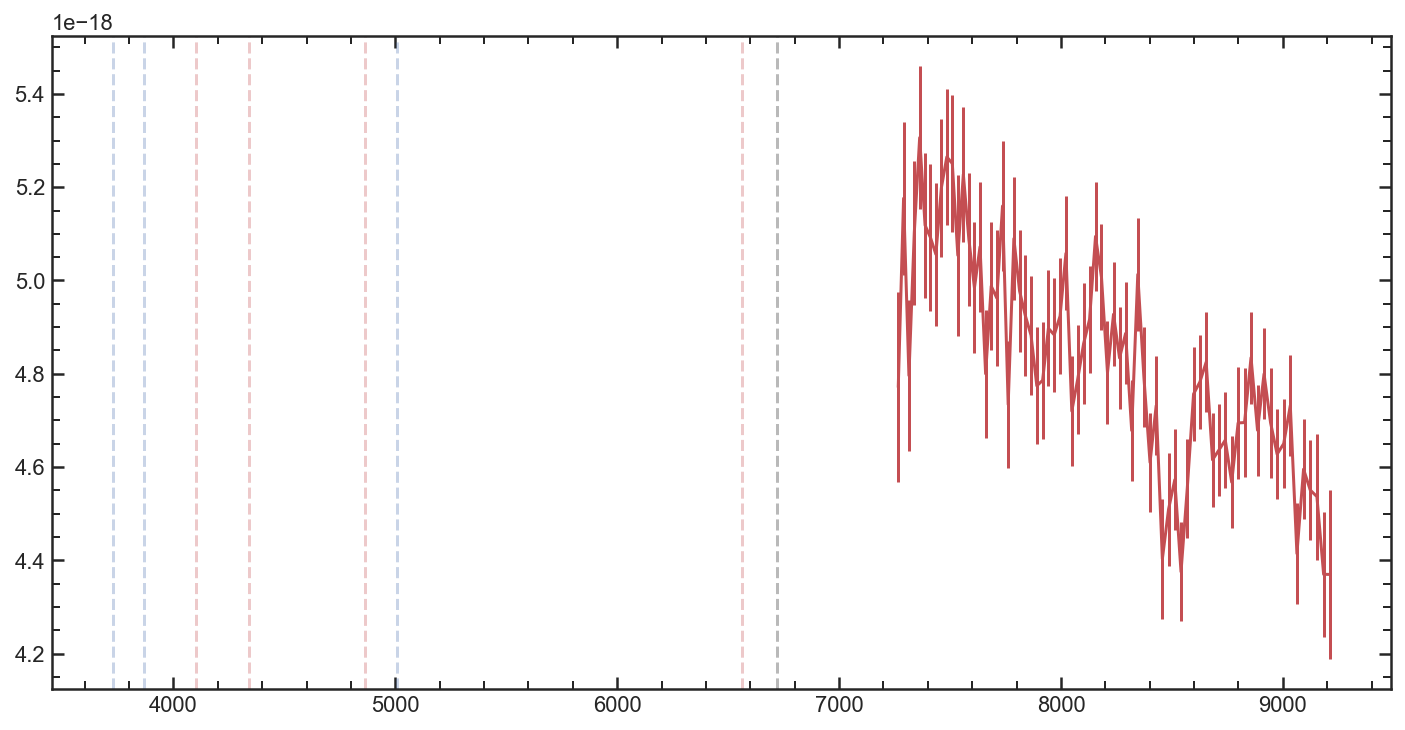

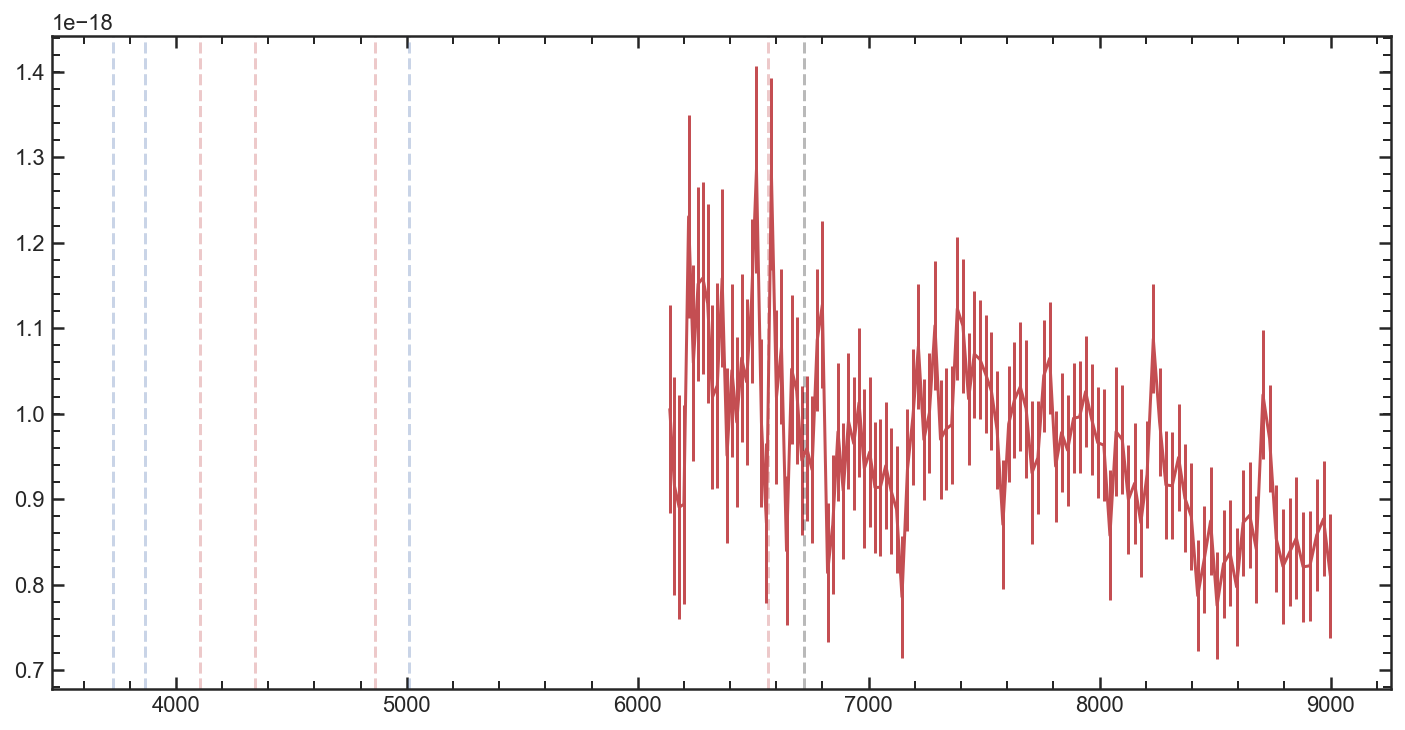

In [107]:
idx = 0
for i in GS_buldge.index:
    if GS_buldge.id[i] not in mdb.query('field == "GSD"').id.values and GS_buldge.id[i] not in SFdb.query('field == "GSD"').id.values:
        G102 = Extract_g102('GSD', GS_buldge.id[i])
        G141 = Extract_g141('GSD', GS_buldge.id[i])      
        
        photz = GS_buldge.zphot[i]
        fig, ax = plt.subplots(figsize = [12,6])
        print(GS_buldge.id[i])
        if G102 is not None:
            ax.errorbar(G102[0] / (1+photz), G102[1] / G102[3], G102[2] / G102[3], color = 'b')
        
        if G141 is not None:
            ax.errorbar(G141[0] / (1+photz), G141[1] / G141[3], G141[2] / G141[3], color = 'r')
        
        ax.axvline(3727.092 ,linestyle='--', alpha=.3)
        ax.axvline(3867 ,linestyle='--', alpha=.3)
        ax.axvline(4102.89 ,linestyle='--', alpha=.3, color = 'r')
        ax.axvline(4341.68 ,linestyle='--', alpha=.3, color = 'r')
        ax.axvline(4862.68 ,linestyle='--', alpha=.3, color = 'r')
        ax.axvline(5008.240 ,linestyle='--', alpha=.3)
        ax.axvline(6564.61 ,linestyle='--', alpha=.3, color = 'r')
        ax.axvline(6718.29,linestyle='--', alpha=.3, color = 'k')
        
        idx += 1
        
        if idx == 2:
            break

In [108]:
GND_bad = [12543,18087,19725,20538,21618,23249,26923,30345,33777,36456,37717,38111]
GSD_bad = [18169,18201,18354,20778,20960,21978,23048,24622,26914,27285,27573,29928,27573,29928,30152,30712,31549,31553,31907,36183,\
           37374,39690,40985,43811,44725,45993,46500]

In [114]:
good_spec = np.repeat(1, len(GS_buldge))
idx = 0
for i in GS_buldge.index:
    if GS_buldge.id[i] in GSD_bad:
        good_spec[idx] = 0
    idx+=1
    
GS_buldge['good_spec'] = good_spec

good_spec = np.repeat(1, len(GN_buldge))
idx = 0
for i in GN_buldge.index:
    if GN_buldge.id[i] in GND_bad:
        good_spec[idx] = 0
    idx+=1
    
GN_buldge['good_spec'] = good_spec

In [117]:
GS_insamp = GS_buldge.query('good_spec >0')
GN_insamp = GN_buldge.query('good_spec >0')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


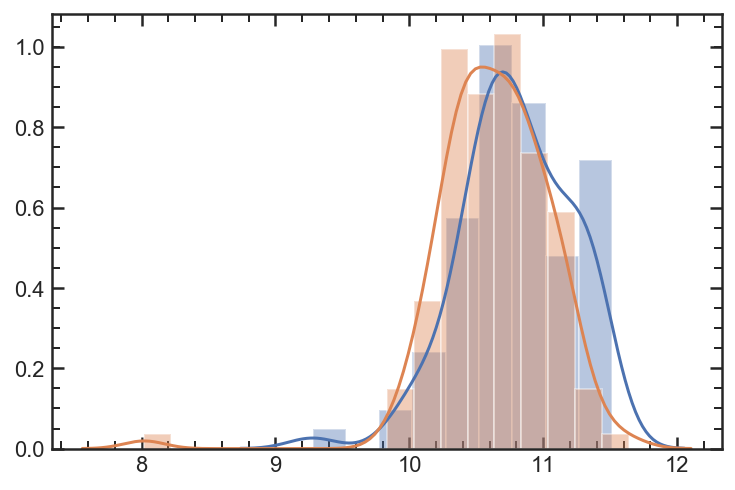

In [122]:
sea.distplot(np.log10(GS_insamp.mass.values))
sea.distplot(np.log10(GN_insamp.mass.values))

# find AGN

In [3]:
GS_insamp = pd.read_pickle('../dataframes/galaxy_frames/GS_buldge_insamp.pkl')
GN_insamp = pd.read_pickle('../dataframes/galaxy_frames/GN_buldge_insamp.pkl')

In [3]:
GS_insamp

,dec,f125,f160,id,mass,ra,star,use,zerr,zphot,good_spec,AGN
3,-27.819326,108.504725,148.151794,19148,2.855285e+11,53.164983,0.03,1,0.003883,0.972842,1,-
5,-27.814061,3.639304,9.645414,20788,2.103093e+11,53.165278,0.77,1,0.008167,3.114503,1,AGN
7,-27.809963,2.480320,4.528888,21615,3.119863e+10,53.185823,0.98,1,0.006635,2.644170,1,AGN
10,-27.803386,6.238111,15.258882,23073,1.693520e+11,53.123106,0.90,1,0.004003,2.318690,1,-
11,-27.799544,101.359559,139.712521,23237,1.181000e+11,53.163407,0.16,1,0.003883,0.664418,1,-
12,-27.802087,13.271765,19.891217,23421,6.953862e+10,53.137760,0.07,1,0.007180,1.188682,1,AGN
13,-27.798734,13.430989,20.139403,24062,4.536661e+10,53.119869,0.03,1,0.006376,1.401783,1,-
14,-27.797520,6.510486,9.431394,24289,5.273826e+10,53.140305,0.90,1,0.007156,1.780704,1,AGN
15,-27.797654,3.729362,6.301513,24315,4.509743e+10,53.162991,0.93,1,0.006161,2.008242,1,-
16,-27.797153,8.852924,14.610538,24569,9.954398e+10,53.158798,0.87,1,0.006545,1.895988,1,-


In [123]:
GSD_X = Table.read('../data/clear_gdsxray.dat', format = 'ascii').to_pandas()
GND_X = Table.read('../data/clear_gdnxray.dat', format = 'ascii').to_pandas()

In [124]:
AGN = []
for i in GS_insamp.index:
    AGN.append(GSD_X.query('ID == {}'.format(GS_insamp.id[i])).Xclass.values[0])

GS_insamp['AGN'] = AGN


AGN = []
for i in GN_insamp.index:
    AGN.append(GND_X.query('ID == {}'.format(GN_insamp.id[i])).Xclass.values[0])

GN_insamp['AGN'] = AGN

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [11]:
v4N_samp[:5]

,id,ra_x,dec_x,z_spec,nusefilt,lc_min,lc_max,numpeaks,z_phot,z_phot_chi2,...,f125_y,f160_y,mass_y,ra_y,star_y,use_y,zerr,zphot,good_spec,AGN
0,11279,189.146989,62.197751,1.2230,23,3592.809617,79157.486154,1,1.205850,37.494729,...,7.061649,10.334027,3.371336e+10,189.146989,0.93,1,0.017355,1.197328,1,AGN
1,11460,189.153153,62.198915,0.5561,23,3592.809617,79157.486154,1,0.528157,401.800328,...,38.735863,51.785706,1.318115e+10,189.153153,0.68,1,0.007317,0.526503,1,AGN
2,12078,189.166744,62.202054,1.0166,23,3592.809617,79157.486154,1,0.988790,58.950456,...,36.650701,47.108538,5.552161e+10,189.166744,0.05,1,0.005734,0.990047,1,-
3,12451,189.164341,62.203273,-1.0000,23,3592.809617,79157.486154,1,0.998231,54.015211,...,10.129892,13.483999,2.456167e+10,189.164341,0.90,1,0.008540,0.995244,1,-
4,12478,189.255064,62.203745,1.5160,23,3592.809617,79157.486154,1,1.288204,27.183664,...,7.013311,10.086366,2.993728e+10,189.255064,0.91,1,0.010275,1.286492,1,-


In [10]:
GN_insamp[:5]

,dec,f125,f160,id,mass,ra,star,use,zerr,zphot,good_spec,AGN
0,62.197751,7.061649,10.334027,11279,3.371336e+10,189.146989,0.93,1,0.017355,1.197328,1,AGN
1,62.198915,38.735863,51.785706,11460,1.318115e+10,189.153153,0.68,1,0.007317,0.526503,1,AGN
2,62.202054,36.650701,47.108538,12078,5.552161e+10,189.166744,0.05,1,0.005734,0.990047,1,-
3,62.203273,10.129892,13.483999,12451,2.456167e+10,189.164341,0.90,1,0.008540,0.995244,1,-
4,62.203745,7.013311,10.086366,12478,2.993728e+10,189.255064,0.91,1,0.010275,1.286492,1,-


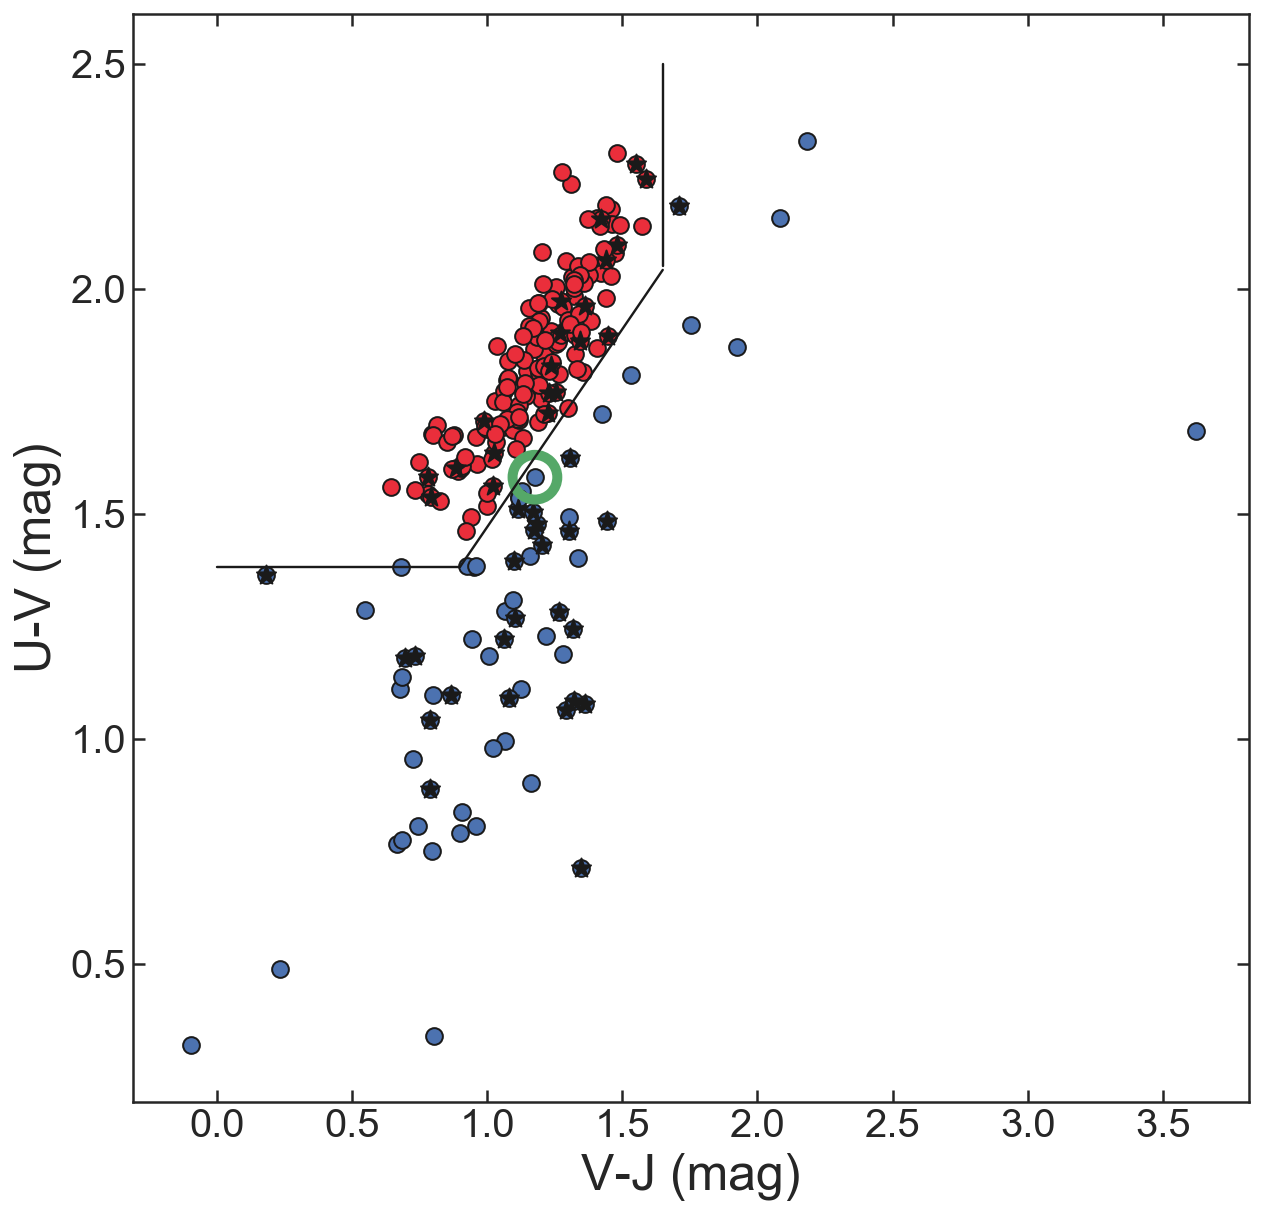

In [14]:
v4N_samp = pd.merge(v4N, GN_insamp, on=['id'], how='inner')
v4S_samp = pd.merge(v4S, GS_insamp, on=['id'], how='inner')

def Color(band1, band2):
    m1=-2.5*np.log10(band1)
    m2=-2.5*np.log10(band2)
    return m1-m2

NUV_s = Color(v4N_samp.restU, v4N_samp.restV)
NVJ_s = Color(v4N_samp.restV, v4N_samp.restJ)
SUV_s = Color(v4S_samp.restU, v4S_samp.restV)
SVJ_s = Color(v4S_samp.restV, v4S_samp.restJ)

SSF = np.repeat('SF', len(GS_insamp))
NSF = np.repeat('SF', len(GN_insamp))

SQ_s = []
NQ_s = []
Ssf_s = []
Nsf_s = []

idx = 0
for i in NUV_s.index:
    if NUV_s[i]>=0.88*NVJ_s[i]+0.59 and NUV_s[i]>1.382 and NVJ_s[i]<1.65:
        NQ_s.append(i)
        NSF[idx] = 'Q'
    else:
        Nsf_s.append(i)
        NSF[idx] = 'SF'
    idx += 1 
    
idx = 0
for i in SUV_s.index:
    if SUV_s[i]>=0.88*SVJ_s[i]+0.59 and SUV_s[i]>1.382 and SVJ_s[i]<1.65 and i != 48719: 
        SQ_s.append(i)
        SSF[idx] = 'Q'
    else:
        Ssf_s.append(i)
        SSF[idx] = 'SF'
        
    idx += 1 
               
plt.figure(figsize=[10,10])

plt.scatter(SVJ_s[SQ_s], SUV_s[SQ_s],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')
plt.scatter(NVJ_s[NQ_s], NUV_s[NQ_s],marker = 'o', s=70, color = '#EA2E3B',linewidths=1, edgecolors='k')

plt.scatter(SVJ_s[Ssf_s], SUV_s[Ssf_s],marker = 'o', s=70, color = 'b',linewidths=1, edgecolors='k')
plt.scatter(NVJ_s[Nsf_s], NUV_s[Nsf_s],marker = 'o', s=70, color = 'b',linewidths=1, edgecolors='k')

for i in SQ_s:
    if v4S_samp.AGN[i] == 'AGN':
        plt.scatter(SVJ_s[i], SUV_s[i],marker = '*', s=100, color = 'k')

for i in NQ_s:
    if v4N_samp.AGN[i] == 'AGN':
        plt.scatter(NVJ_s[i], NUV_s[i],marker = '*', s=100, color = 'k')

for i in Ssf_s:
    if v4S_samp.AGN[i] == 'AGN':
        plt.scatter(SVJ_s[i], SUV_s[i],marker = '*', s=100, color = 'k')

for i in Nsf_s:
    if v4N_samp.AGN[i] == 'AGN':
        plt.scatter(NVJ_s[i], NUV_s[i],marker = '*', s=100, color = 'k')
#39364

for i in NUV_s.index:
    if v4N_samp.id[i] == 35090:
        plt.scatter(NVJ_s[i], NUV_s[i],marker = 'o', s=500,linewidth = 5, color = 'None', edgecolor = 'g')


plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)
# plt.axis([0,2.5,.5,2.5])

plt.xlabel('V-J (mag)', fontsize=25)
plt.ylabel('U-V (mag)', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)

In [136]:
len(SQ_s) + len(NQ_s), len(Ssf_s) + len(Nsf_s), len(GS_insamp.query('AGN == "AGN"')) + len(GN_insamp.query('AGN == "AGN"'))

(151, 68, 45)

In [16]:
GN_insamp['SF'] = NSF
GS_insamp['SF'] = SSF

In [17]:
GS_insamp.to_pickle('../dataframes/galaxy_frames/GS_buldge_insamp.pkl')
GN_insamp.to_pickle('../dataframes/galaxy_frames/GN_buldge_insamp.pkl')

In [21]:
GS_SF = GS_insamp.query('SF == "SF"')
GS_Q = GS_insamp.query('SF == "Q"')
GN_SF = GN_insamp.query('SF == "SF"')
GN_Q = GN_insamp.query('SF == "Q"')

In [22]:
GS_SF.to_pickle('../dataframes/galaxy_frames/GS_buldge_SF.pkl')
GS_Q.to_pickle('../dataframes/galaxy_frames/GS_buldge_Q.pkl')
GN_SF.to_pickle('../dataframes/galaxy_frames/GN_buldge_SF.pkl')
GN_Q.to_pickle('../dataframes/galaxy_frames/GN_buldge_Q.pkl')

In [35]:
buldge_meas = buldge_meas[['field','id','candels_id','lwa', 'lwa_hci', 'lwa_modality', 'Av','Av_hci', 'Av_modality', 'Z', 'Z_hci', 'Z_modality', 'lmass', \
                             'lmass_hci', 'lmass_modality', 'zgrism', 'z_50', 'z_50_hci', 'z_50_modality', 't_50', \
                             't_50_hci', 't_50_modality', 'log_ssfr', 'log_ssfr_hci', 'log_ssfr_modality']]

In [36]:
buldge_meas.to_csv('../dataframes/galaxy_frames/goods_bulge_stellar_params.dat',sep = ' ', index=False)
buldge_meas.to_pickle('../dataframes/galaxy_frames/goods_bulge_stellar_params.pkl')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


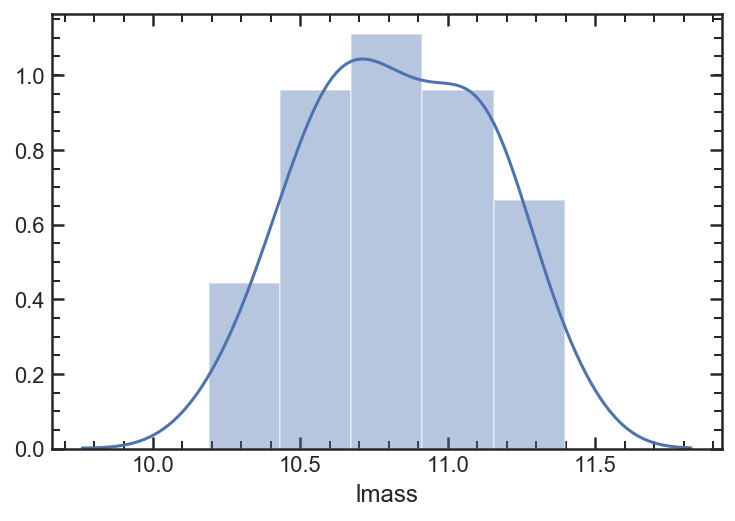

In [37]:
sea.distplot(buldge_meas.lmass)

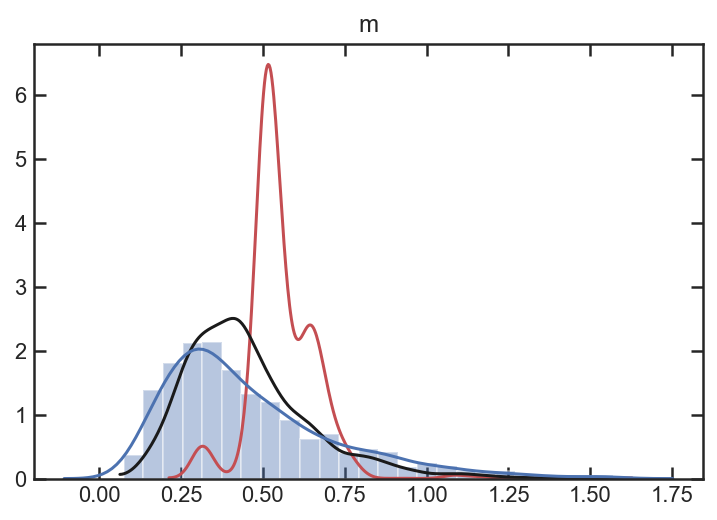

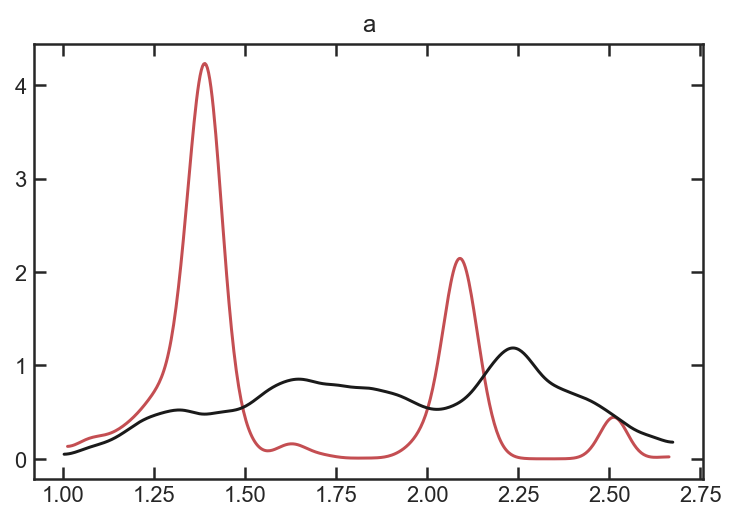

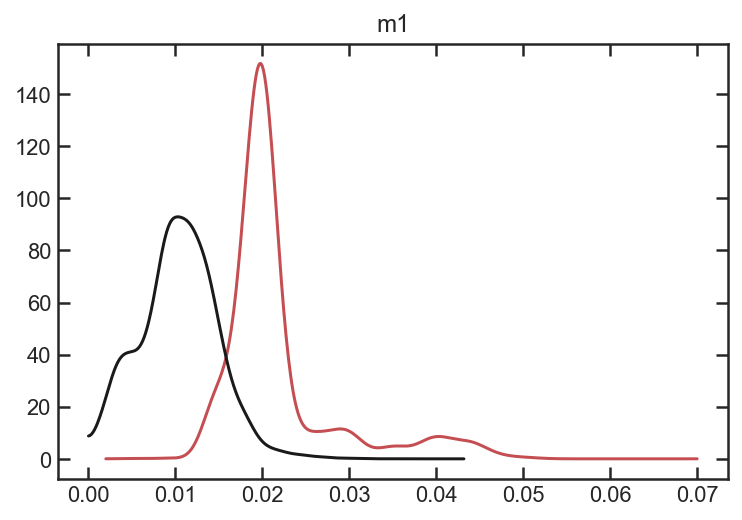

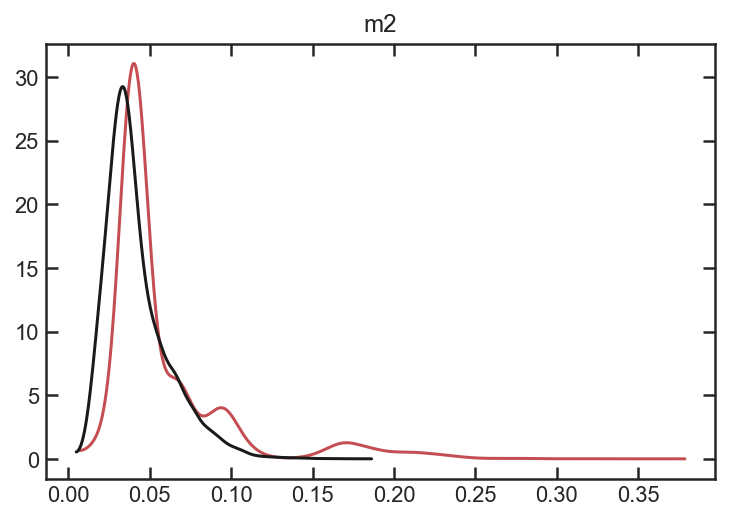

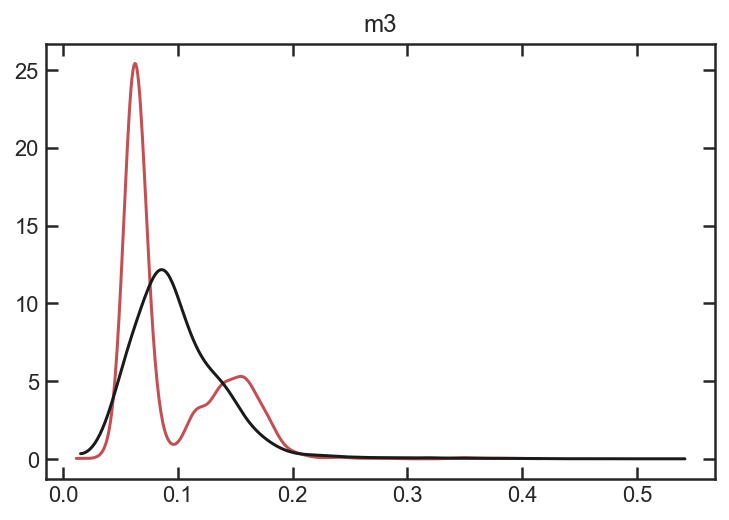

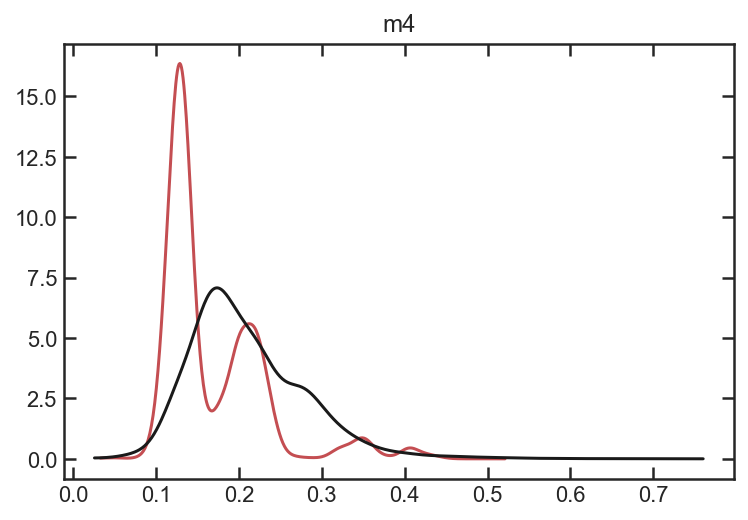

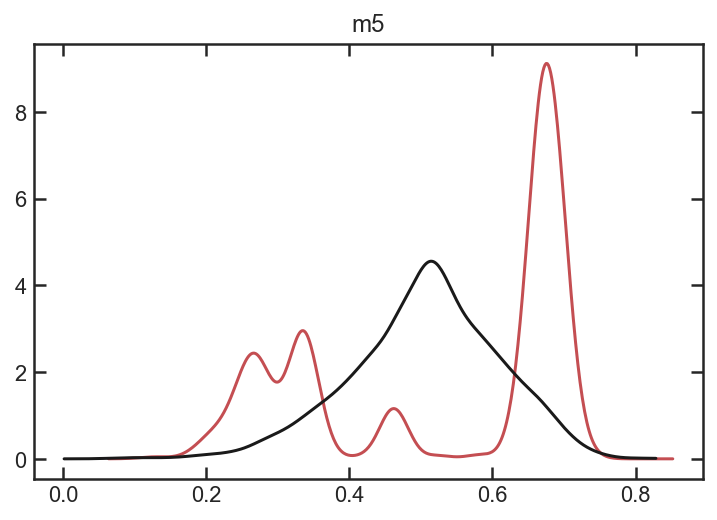

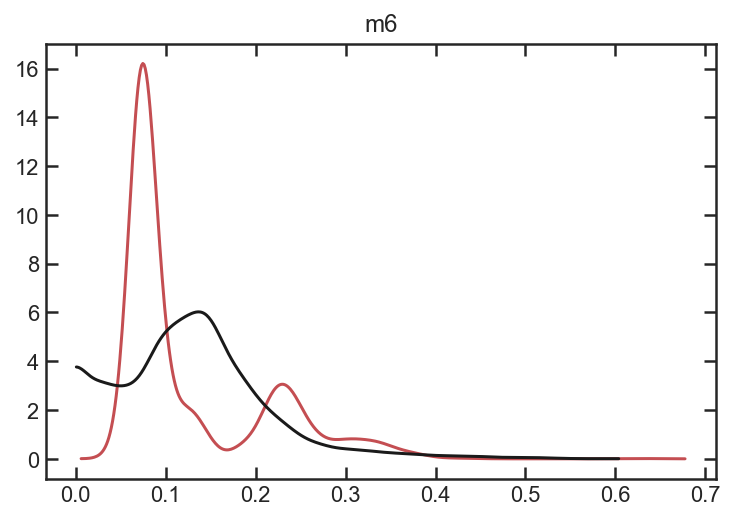

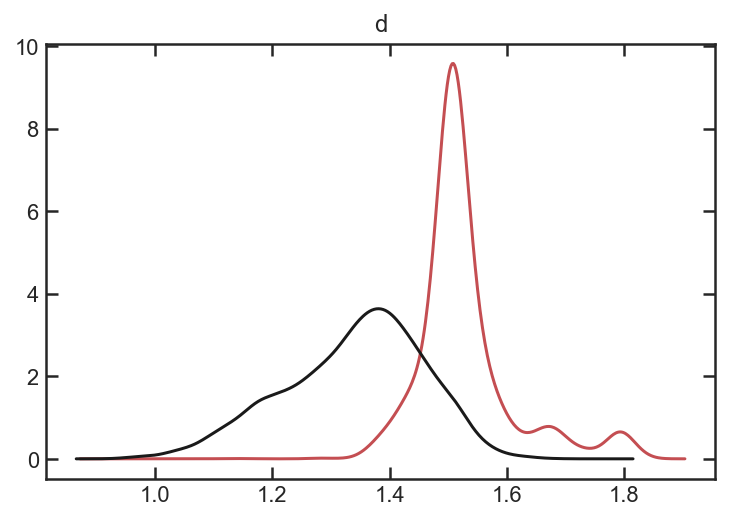

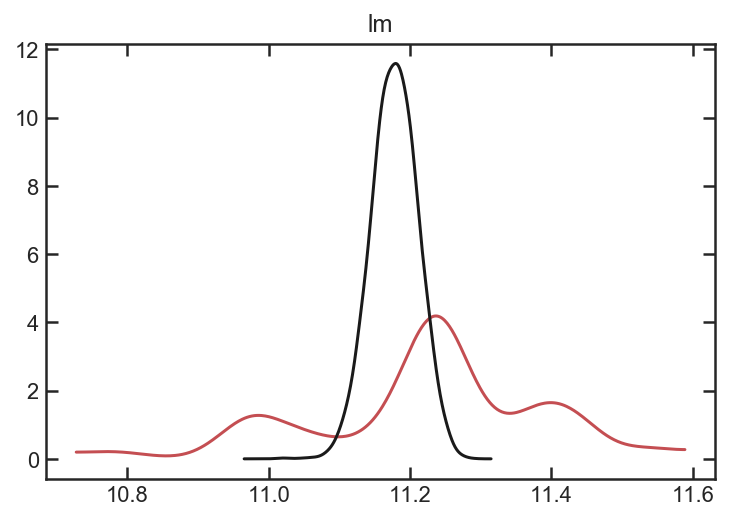

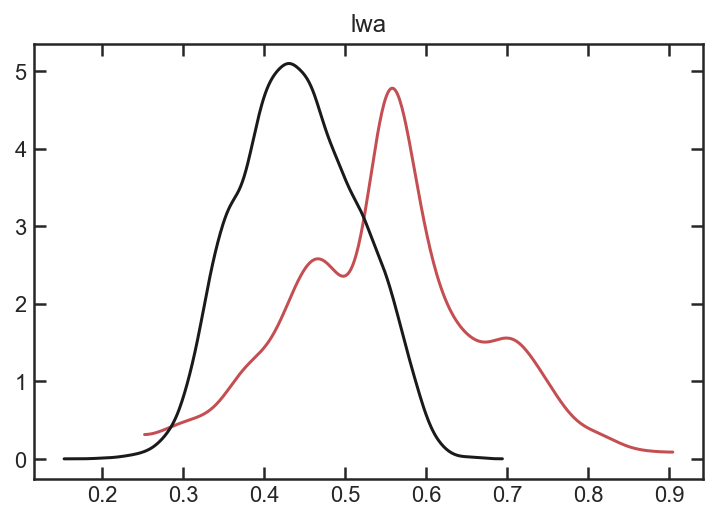

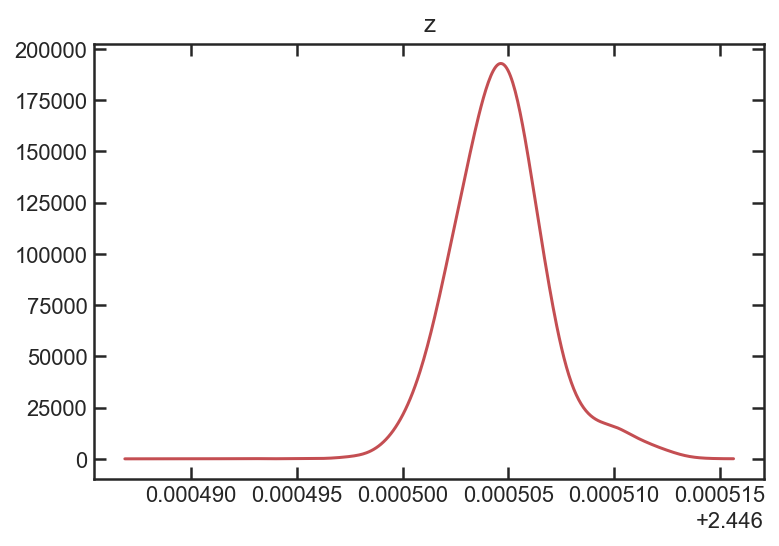

In [13]:
def Z_prior_mu(lmass):
    M = [9, 11.5]
    P = [-0.5813, 0.06818]
    iP = interp1d(M,P)
    return iP(lmass) 

onesig = (0.04 + 0.47)/2
mllim = np.log10(0.001 / 0.019)
mhlim = np.log10(0.031 / 0.019)


params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'd', 'lm', 'lwa', 'z']
for i in range(len(params)):
    plt.figure()
    plt.title(params[i])
    
    y,py = np.load('../data/posteriors/GSD_45068_SFMfit_P{0}.npy'.format(params[i]))
    plt.plot(y,py,'r') 
    
    
    if params[i] != 'z':
        y,py = np.load('../Casey_data/posteriors/GSD_45068_SFfit_p1_P{0}.npy'.format(params[i]))
        plt.plot(y,py,'k') 
        
    if params[i] == 'm':
        sea.distplot(10**Gaussian_prior(np.random.rand(1000), [mllim, mhlim], Z_prior_mu(9.732068638965309), onesig))

        
#     if params[i] == 'z':
#         print(y[py == max(py)])
#         plt.xlim(2.446,2.448)

In [22]:
from grizli.utils import SpectrumTemplate
from spec_tools import Gen_PPF
from spec_id_2d import spec_construct

def Derive_nuiscance_SFfits(ppf_dict, sp, Gs, mb_g102, mb_g141, specz, draws = 1000):
    SF_temps =  Gen_temp_dict(specz, 8000, 16000)
    wave0=4000
    linestr = {}
    
    for k in SF_temps:
        linestr[k] = []
    
    
    lm = []
    lwa = []
    sl_b = []
    sl_r = []
    
    idx=0
    while idx < draws:
        try:
            draw = np.zeros(len(params))
            for ii in range(len(draw)):
                draw[ii] = ppf_dict[params[ii]](np.random.rand(1))[0]

            sp.params['dust2'] = draw[8]
            sp.params['logzsol'] = np.log10(draw[0])

            time, sfr, tmax = convert_sfh(get_agebins(draw[1], binnum = 6), draw[2:8], maxage = draw[1]*1E9)

            sp.set_tabular_sfh(time,sfr) 

            wave, flux = sp.get_spectrum(tage = draw[1], peraa = True)

            SF_temps['fsps_model_slope'] = SpectrumTemplate(wave=wave, flux=flux*(wave-wave0)/wave0)
            SF_temps['fsps_model'] = SpectrumTemplate(wave, flux)

            g102_fit = mb_g102.template_at_z(draw[9] , templates=SF_temps, fitter='lstsq')
            g141_fit = mb_g141.template_at_z(draw[9] , templates=SF_temps, fitter='lstsq')

            for k in linestr:
                lineflux = np.array([g102_fit['cfit'][k][0],g141_fit['cfit'][k][0]])

                linestr[k].append(sum(lineflux) / len(lineflux[lineflux > 0]) )

            sl_b.append(g102_fit['cfit']['fsps_model_slope'][0])
            sl_r.append(g141_fit['cfit']['fsps_model_slope'][0])

            wv_obs, flx = spec_construct(g102_fit,g141_fit,draw[9])
            iflux = interp1d(wave*(1+draw[9]), flux)(wv_obs[flx**2 > 0])

            flam = F_lam_per_M(flx * (iflux[50]/flx[50]),wv_obs, draw[9], 0, sp.stellar_mass)
            Pmfl = Gs.Sim_phot_mult(wv_obs,flam)
            scl = Scale_model(Gs.Pflx, Gs.Perr, Pmfl)

            lm.append(np.log10(scl))

            lwa.append(get_lwa_SF(draw[:8], get_agebins(draw[1], binnum = 6),sp)[0])

            idx +=1
        except:
            pass
        
    return lm, lwa, sl_b, sl_r, linestr

In [3]:
field = 'GSD'
galaxy = 45068

beams = mfit_path + '{}_{}.beams.fits'.format(field, galaxy)

mb_g102, mb_g141 = Gen_multibeams(beams, args = args)

sp = fsps.StellarPopulation(zcontinuous = 1, logzsol = 0, sfh = 3, dust_type = 2)
sp.params['dust1'] = 0

###########gen spec##########
Gs = Gen_SF_spec(field, galaxy, 1, phot_errterm = 0.04, irac_err = 0.08) 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3553: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3558: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3559: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))


1 ibhj03xoq_flt.fits G141
2 ibhj03xvq_flt.fits G141
3 ibhj03y2q_flt.fits G141
4 ibhj03y9q_flt.fits G141
5 ibhj11hiq_flt.fits G141
6 ibhj11hpq_flt.fits G141
7 ibhj11hwq_flt.fits G141
8 ibhj11i3q_flt.fits G141
9 icxt01cgq_flt.fits G102
10 icxt01ciq_flt.fits G102
11 icxt01clq_flt.fits G102
12 icxt01cnq_flt.fits G102
13 icxt02c7q_flt.fits G102
14 icxt02caq_flt.fits G102
15 icxt02cdq_flt.fits G102
16 icxt02cfq_flt.fits G102
17 icxt03jjq_flt.fits G102
18 icxt03jkq_flt.fits G102
19 icxt03jnq_flt.fits G102
20 icxt03jpq_flt.fits G102
21 icxt04e3q_flt.fits G102
22 icxt04edq_flt.fits G102
23 icxt04efq_flt.fits G102
24 icxt05h7q_flt.fits G102
25 icxt05h9q_flt.fits G102
26 icxt05hcq_flt.fits G102
27 icxt05heq_flt.fits G102
28 icxt06laq_flt.fits G102
29 icxt06lcq_flt.fits G102
30 icxt06lfq_flt.fits G102
31 icxt06lhq_flt.fits G102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1433: RuntimeWarning: divide by zero encountered in true_divide
  beam.ivarf = 1./(1/beam.ivarf + (sys_err*beam.scif)**2)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1573: RuntimeWarning: invalid value encountered in sqrt
  self.sivarf = np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/multifit.py:1578: RuntimeWarning: invalid value encountered in sqrt
  self.weightf = np.exp(-(self.fcontam*np.abs(self.contamf)*np.sqrt(self.ivarf)))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.13.0_167_g5e9ee7c-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:557: RuntimeWarning: divide by zero encountered in true_divide
  se

In [7]:
params = ['m', 'a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'd', 'z']
#        [ 0 ,  1 ,   2 ,   3 ,   4 ,   5 ,   6 ,   7 ,  8 ,  9 ]

ppf_dict = {}

for i in params:
    x,px = np.load('../data/posteriors/GSD_45068_SFMfit_P{}.npy'.format(i))
    ppf_dict[i] = Gen_PPF(x,px)

In [23]:
lm, lwa, slB, slR, linestr = Derive_nuiscance_SFfits(ppf_dict, sp, Gs, mb_g102, mb_g141, 2.44696282, draws=1000)


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in double_scalars
/Users/vestrada/Github/Cluster_and_field/scripts/spec_id_2d.py:130: RuntimeWarning: invalid value encountered in true_divide
  line_g141 = (g141_fit['line1d'].flux - g141_fit['cont1d'].flux)/g141_fit['cont1d'].flux
/Users/vestrada/Github/Cluster_and_field/scripts/spec_id_2d.py:139: RuntimeWarning: invalid value encountered in true_divide
  line_g102 = (g102_fit['line1d'].flux - g102_fit['cont1d'].flux)/g102_fit['cont1d'].flux
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater


In [24]:
from spec_tools import boot_to_posterior

LM, PLM = boot_to_posterior(lm, np.ones_like(lm))
np.save('../data/posteriors/GSD_45068_SFMfit_Plm', [LM, PLM])

LWA, PLWA = boot_to_posterior(lwa, np.ones_like(lwa))
np.save('../data/posteriors/GSD_45068_SFMfit_Plwa', [LWA, PLWA])

SLB, PSLB = boot_to_posterior(slB, np.ones_like(slB))
np.save('../data/posteriors/GSD_45068_SFMfit_Pslb', [SLB, PSLB])

SLR, PSLR = boot_to_posterior(slR, np.ones_like(slR))
np.save('../data/posteriors/GSD_45068_SFMfit_Pslr', [SLR, PSLR])

In [28]:
linestr.keys()

dict_keys(['line OII', 'line NeVI-3426', 'line NeV-3346', 'line H10', 'line OIII-4363', 'line H7', 'line NeIII-3867', 'line H8', 'line Hd', 'line MgII', 'line Hg', 'line H9'])

In [36]:
lnflx = np.array(linestr['line NeV-3346'])
lnflx = lnflx[~np.isinf(lnflx)]
lnflx = lnflx[~np.isnan(lnflx)]

array([-4.28394840e-17, -4.31339988e-17, -4.34703387e-17, -4.25714732e-17,
       -4.15980566e-17, -4.16529479e-17, -4.11748434e-17, -4.17607759e-17,
       -4.34118195e-17, -3.99621703e-17, -4.33256334e-17, -4.35690168e-17,
       -4.32041749e-17, -4.18197040e-17, -4.20820695e-17, -3.92643039e-17,
       -4.17153290e-17, -4.49424942e-17, -4.35709711e-17, -4.22845935e-17,
       -4.29329043e-17, -3.92655590e-17, -4.42994714e-17, -4.19255714e-17,
       -4.36064726e-17, -4.18596582e-17, -4.35481976e-17, -4.18588303e-17,
       -4.09400055e-17, -3.99729949e-17, -4.06269408e-17, -4.22115785e-17,
       -4.35347493e-17, -4.31271384e-17, -4.13009920e-17, -4.39671791e-17,
       -4.44011040e-17, -4.36034185e-17, -4.17530370e-17, -4.31730862e-17,
       -4.26106574e-17, -4.25335545e-17, -4.33043648e-17, -4.35675689e-17,
       -4.43496403e-17, -4.32694585e-17, -4.32711410e-17, -4.20345467e-17,
       -4.11899579e-17, -4.39232395e-17, -4.51063168e-17, -4.30702966e-17,
       -4.24473132e-17, -

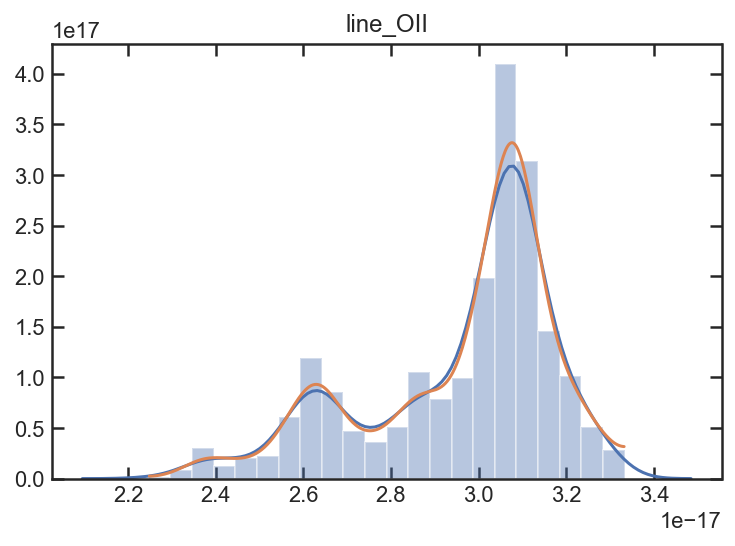

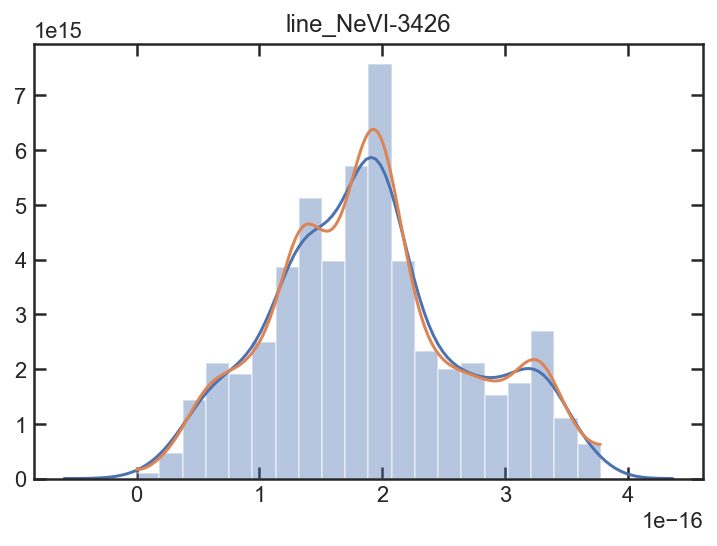

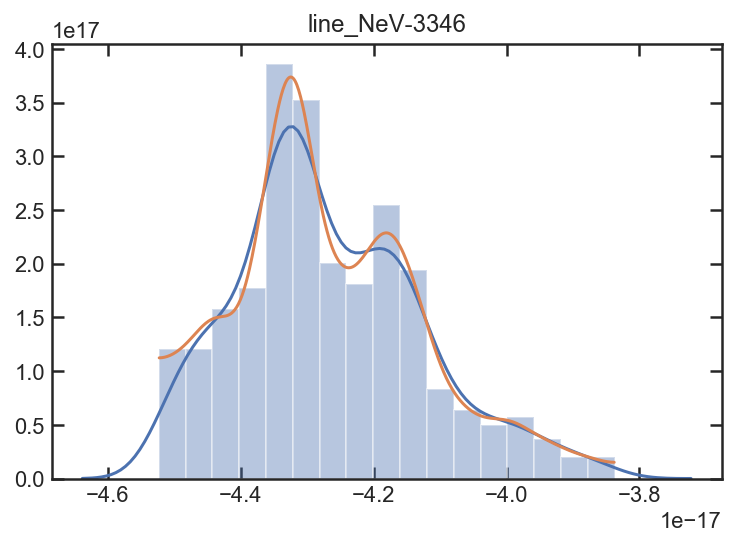

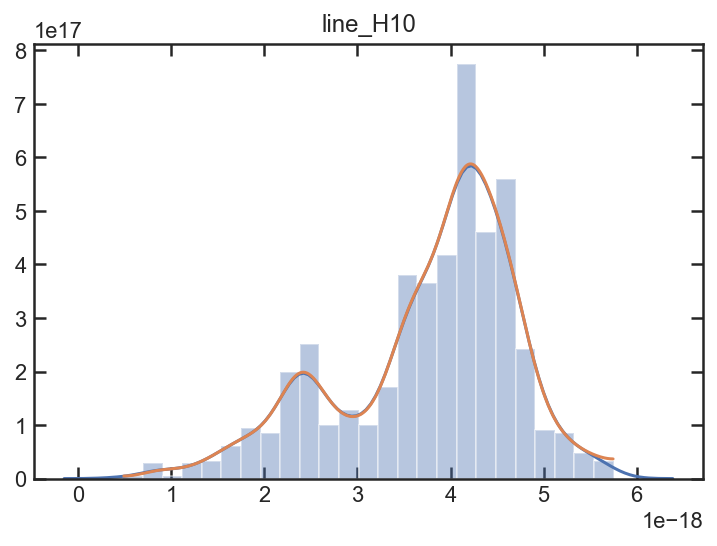

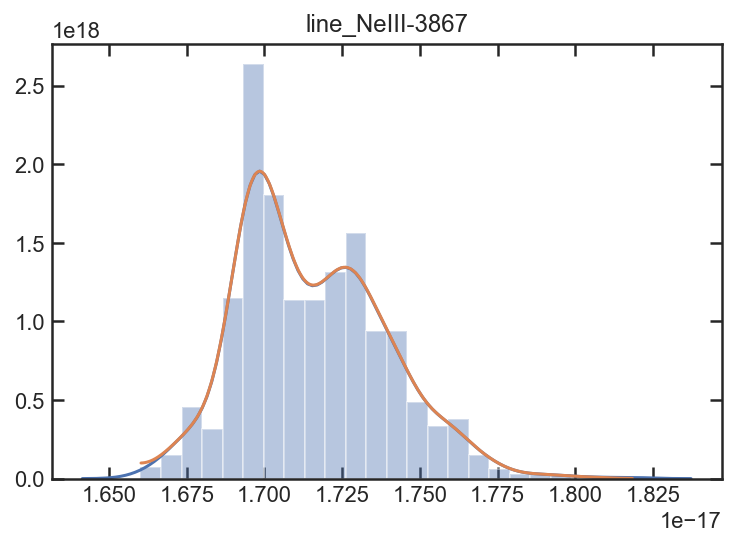

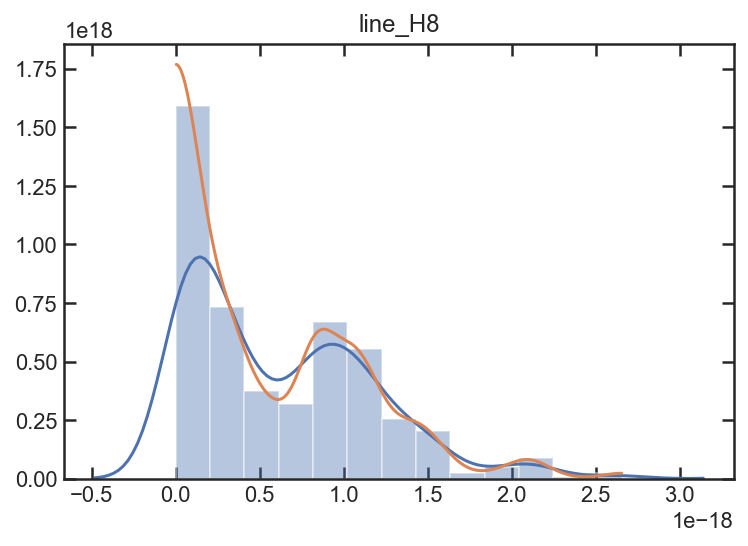

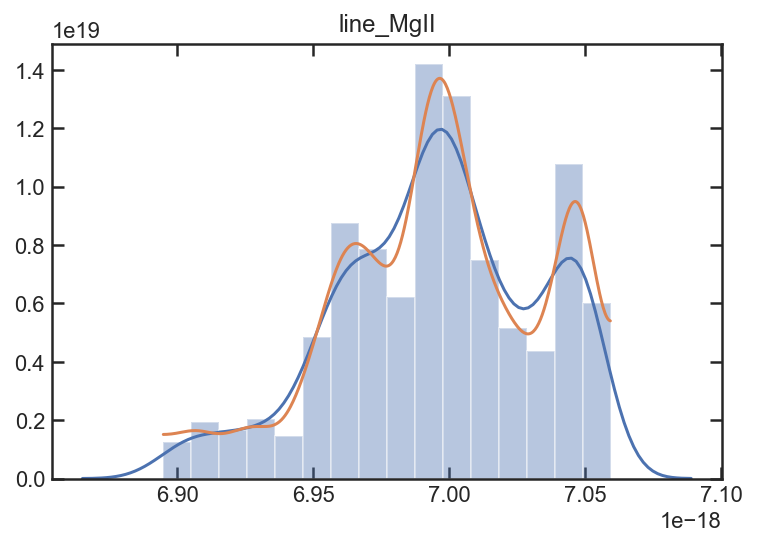

In [41]:
for i in linestr:
    lnflx = np.array(linestr[i])
    lnflx = lnflx[~np.isinf(lnflx)]
    lnflx = lnflx[~np.isnan(lnflx)]
    
    try:
        X, PX = boot_to_posterior(lnflx, np.ones_like(lnflx))

        plt.figure()
        sea.distplot(lnflx)
        plt.plot(X,PX)
        plt.title(i.split(' ')[0] + '_' + i.split(' ')[1])

        np.save('../data/posteriors/GSD_45068_SFMfit_P{}'.format(i.split(' ')[0] + '_' + i.split(' ')[1]), [X,PX])

        
    except:
        pass


In [48]:
from spec_tools import Derive_SFH_weights, z_at_value, boot_to_posterior, Rescale_SF_sfh
import astropy.units as u
class Rescale_SF_sfh_m(object):
    def __init__(self, field, galaxy, trials = 1000):

        ppf_dict = {}
        params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_SFMfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0
        x,px = np.load('../data/posteriors/{0}_{1}_SFMfit_Pz.npy'.format(field, galaxy))
        rshift = x[px == max(px)][0]
        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []
        ssfr_grid = []
        t_50_grid = []

        while idx < trials:
            try:
                draw = np.zeros(len(params))

                for i in range(len(draw)):
                    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                time, sfr, tmax = convert_sfh(get_agebins(draw[0], binnum=6), draw[1:7], maxage = draw[0]*1E9)

                T=[0]
                M=[0]
                for i in range(len(time)//2):
                    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                    M.append(M[i] + mass)
                    T.append(time[i*2+1])

                sfr = sfr/ M[-1] * 10**draw[7] / 1E9

                lbt = np.abs(time - time[-1])[::-1]
                lbsfr = sfr[::-1]

                T=[0]
                M=[0]
                for i in range(len(lbt)//2):
                    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
                    M.append(M[i] + mass)
                    T.append(lbt[i*2+1])

                t_50_grid.append(interp1d(M/ M[-1], T)(0.5))

                sfrmax = np.argmax(lbsfr) 

                sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

                ssfr_grid.append(lbsfr[0] / 10**draw[7])
                idx +=1
            except:
                pass

        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])
                
        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.ma.masked_less_equal(sfr_grid,1E-10)

        weights = Derive_SFH_weights(self.SFH, sfr_grid[0:trials])
       
        ####### t values
        x,y = boot_to_posterior(t_50_grid[0:trials], weights)
        self.t_50, self.t_50_hci, self.t_50_offreg = Highest_density_region(y,x)
        
        self.t_50 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.5)

        ####### z values
        self.z_50 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_50)*u.Gyr)
        hci=[]
        for lims in self.t_50_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_50_hci = np.array(hci)
        self.z_50_offreg = np.array(self.t_50_offreg)

            
        x,y = boot_to_posterior(np.log10(ssfr_grid[0:trials]), weights)
        self.lssfr, self.lssfr_hci, self.lssfr_offreg = Highest_density_region(y,x)
            
        self.weights = weights
        self.t_50_grid = t_50_grid

In [49]:
sfh1 = Rescale_SF_sfh('GSD', 45068, 2.44696282,'fit_p1')
sfh2 = Rescale_SF_sfh_m('GSD', 45068)

(0, 400)

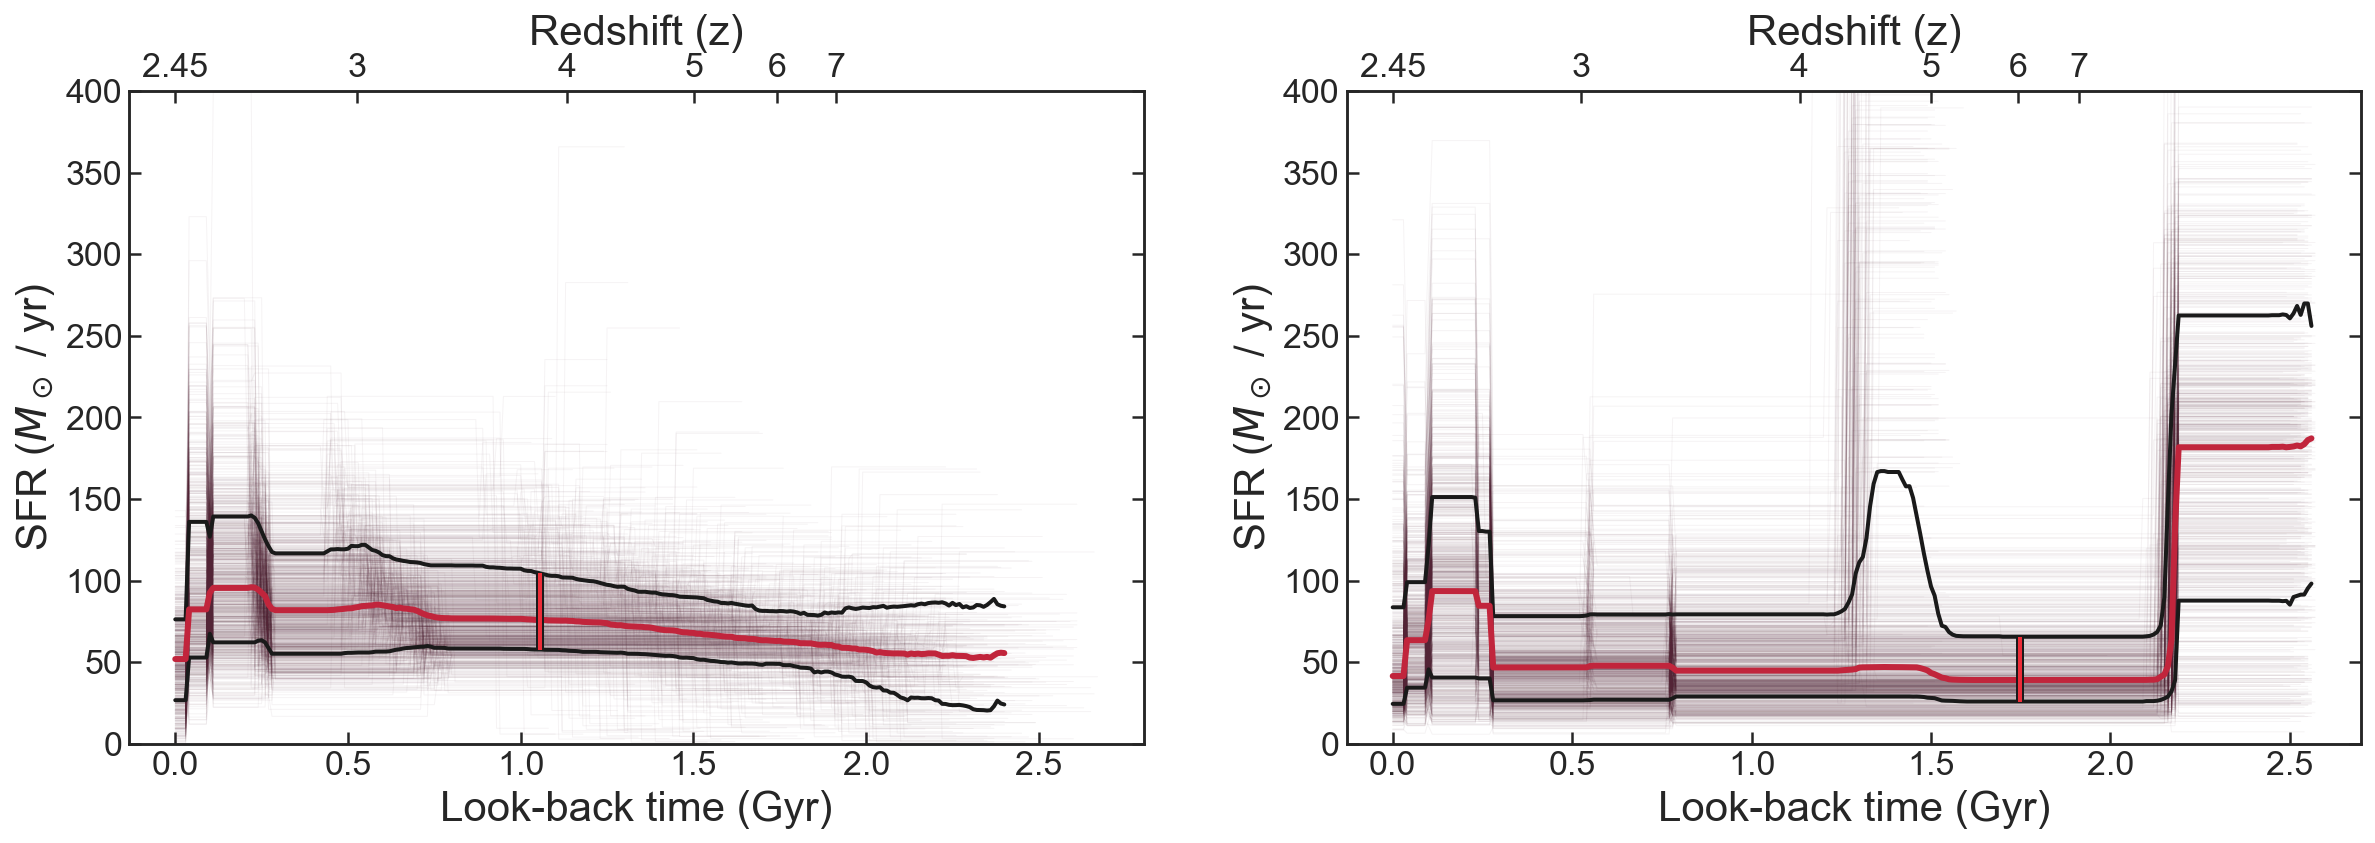

In [54]:
gs = gridspec.GridSpec(1,2)


plt.figure(figsize=[20,6])
ax3 = plt.subplot(gs[0])

isfhl = interp1d(sfh1.LBT,sfh1.SFH_16)
isfhh = interp1d(sfh1.LBT,sfh1.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh1.fulltimes, sfh1.sfr_grid.T[:1000], color = '#532436', alpha=.05, linewidth = 0.5)
ax3.plot(sfh1.LBT,sfh1.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh1.LBT,sfh1.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh1.LBT,sfh1.SFH_84, 'k', linewidth = 2)

max_lbt = np.round(sfh1.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(2.44696282).value
age_at_z = cosmo.lookback_time(2.44696282).value
zarray = [np.round(2.44696282,2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 
    
tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(sfh1.t_50,isfhl(sfh1.t_50), isfhh(sfh1.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(sfh1.t_50,isfhl(sfh1.t_50), isfhh(sfh1.t_50), color = 'k', linewidth = 4, zorder = 10)
ax3.set_ylim(0,400)

ax3 = plt.subplot(gs[1])

isfhl = interp1d(sfh2.LBT,sfh2.SFH_16)
isfhh = interp1d(sfh2.LBT,sfh2.SFH_84)

ax4 = ax3.twiny()

ax3.plot(sfh2.fulltimes, sfh2.sfr_grid.T[:1000], color = '#532436', alpha=.05, linewidth = 0.5)
ax3.plot(sfh2.LBT,sfh2.SFH, color = '#C1253C', linewidth = 3, zorder = 9)
ax3.plot(sfh2.LBT,sfh2.SFH_16, 'k', linewidth = 2)
ax3.plot(sfh2.LBT,sfh2.SFH_84, 'k', linewidth = 2)

max_lbt = np.round(sfh2.fulltimes[-1])
max_age = max_lbt + cosmo.lookback_time(2.44696282).value
age_at_z = cosmo.lookback_time(2.44696282).value
zarray = [np.round(2.44696282,2)]

idx = 0
while cosmo.lookback_time(np.array(zarray[idx])).value  < 13:
    zarray.append(int(zarray[idx])+1)
    idx += 1 
    
tarray =cosmo.lookback_time(np.array(zarray)).value - cosmo.lookback_time(np.array(zarray)).value[0]

ax4.set_xlim(ax3.get_xlim())
ax4.set_xticks(tarray)
ax4.set_xticklabels(zarray)
ax4.xaxis.set_ticks_position('top')

ax3.set_xlabel('Look-back time (Gyr)', fontsize=21)
ax3.set_ylabel('SFR ($M_\odot$ / yr)', fontsize=21)
ax4.set_xlabel('Redshift (z)', fontsize=21) 
ax3.tick_params(axis='both', which='major', labelsize=17)
ax4.tick_params(axis='both', which='major', labelsize=17)

ax3.vlines(sfh2.t_50,isfhl(sfh2.t_50), isfhh(sfh2.t_50), color = '#ED2D39', linewidth = 2, zorder = 11)
ax3.vlines(sfh2.t_50,isfhl(sfh2.t_50), isfhh(sfh2.t_50), color = 'k', linewidth = 4, zorder = 10)
ax3.set_ylim(0,400)


In [15]:
GS_SF = pd.read_pickle('../dataframes/galaxy_frames/GS_buldge_SF.pkl')
GS_Q = pd.read_pickle('../dataframes/galaxy_frames/GS_buldge_Q.pkl')
GN_SF = pd.read_pickle('../dataframes/galaxy_frames/GN_buldge_SF.pkl')
GN_Q = pd.read_pickle('../dataframes/galaxy_frames/GN_buldge_Q.pkl')

In [20]:
GS_toq = GS_SF.query('id in [38513, 39948, 41122, 44194, 45697, 45994]')

GN_toq = GN_SF.query('id in [14784, 35090]')

In [24]:
GS_Qup = pd.concat([GS_Q, GS_toq])
GN_Qup = pd.concat([GN_Q, GN_toq])

In [25]:
GS_SFup = GS_SF.query('id not in [38513, 39948, 41122, 44194, 45697, 45994]')

GN_SFup = GN_SF.query('id not in [14784, 35090]')

In [34]:
z_50 = []

for i in GN_SFup.index:
    gid = GN_SFup.id[i]
    
    fp = glob('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/*N*/*{}*'.format(gid))

    subfield = fp[0].split('/')[-2]

    dat = Table.read(fits.open('/Volumes/Vince_CLEAR/RELEASE_v2.1.0/grizli_v2.1_cats/{0}_lines_grizli.fits'.format(subfield)), format='fits').to_pandas()

    rshift = dat.query('ID == {0}'.format(gid)).z_50.values[0]
    z_50.append(rshift)

In [35]:
GN_SFup['z_50'] = z_50

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [46]:
eazy_cat = Table.read(fits.open('/Volumes/Vince_CLEAR/3dhst_V4.4/goodss_3dhst.v4.4.cats/Eazy/goodss_3dhst.v4.4.zout.fits'),format = 'fits').to_pandas()

lm = []
for i in GS_SFup.index:
    lm.append(np.log10((eazy_cat.query('id == {}'.format(GS_SFup.id[i])).mass.values[0])))
    
GS_SFup['lmass'] = lm

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [49]:
GN_SFup.to_pickle('../dataframes/galaxy_frames/GN_buldge_SFup.pkl')
GN_Qup.to_pickle('../dataframes/galaxy_frames/GN_buldge_Qup.pkl')
GS_SFup.to_pickle('../dataframes/galaxy_frames/GS_buldge_SFup.pkl')
GS_Qup.to_pickle('../dataframes/galaxy_frames/GS_buldge_Qup.pkl')

In [48]:
GS_SFup

,dec,f125,f160,id,mass,ra,star,use,zerr,zphot,good_spec,AGN,SF,z_50,lmass
5,-27.814061,3.639304,9.645414,20788,2.103093e+11,53.165278,0.77,1,0.008167,3.114503,1,AGN,SF,3.005900,11.322858
7,-27.809963,2.480320,4.528888,21615,3.119863e+10,53.185823,0.98,1,0.006635,2.644170,1,AGN,SF,2.455416,10.494135
13,-27.798734,13.430989,20.139403,24062,4.536661e+10,53.119869,0.03,1,0.006376,1.401783,1,-,SF,1.379727,10.656736
24,-27.777502,1.907312,3.096556,29349,1.210069e+10,53.148891,0.95,1,0.017958,1.862501,1,-,SF,2.068447,10.082810
26,-27.775560,6.047710,9.172077,29816,1.766291e+10,53.193096,0.03,1,0.009831,1.277859,1,AGN,SF,1.222988,10.247062
39,-27.743149,3.574255,4.822060,36136,8.098802e+09,53.132631,0.90,1,0.011498,1.942758,1,-,SF,1.896109,9.908421
45,-27.734909,7.877433,15.543472,37745,1.125454e+11,53.182838,0.91,1,0.005124,2.452715,1,-,SF,2.439081,11.051328
54,-27.728352,6.511336,9.380681,39085,4.177698e+10,53.071304,0.03,1,0.029886,1.687025,1,-,SF,1.602888,10.620937
58,-27.726809,3.129479,4.549763,39383,1.025043e+10,53.181085,0.08,1,0.004120,2.033398,1,-,SF,2.078859,10.010742
59,-27.726325,3.088097,7.013115,39568,6.777309e+10,53.058858,0.03,1,0.042864,1.703911,1,-,SF,1.537087,10.831057


In [13]:
import re
from spec_tools import Derive_SFH_weights, boot_to_posterior, z_at_value, Gen_PPF
import astropy.units as u

class Gen_SFH(object):
    def __init__(self, field, galaxy, redshift, trials = 1000):

        ppf_dict = {}
        flist = glob('../data/posteriors/{}_{}_*_Pm*.npy'.format(field,galaxy))


        for f in flist:
            ext = re.split('{}_{}_'.format(field,galaxy),re.split('_Pm[0-9].npy', os.path.basename(f))[0])[1]
            if ext in ['tabfit', 'SFfit_p1']:
                fext = ext
                break

        if fext == 'tabfit':
            params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm']
            x,px = np.load('../data/posteriors/{}_{}_{}_Pz.npy'.format(field, galaxy,fext))
            rshift = x[px == max(px)][0]
        else:
            params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'lm']
            rshift = redshift

        for i in params:
            x,px = np.load('../data/posteriors/{}_{}_{}_P{}.npy'.format(field, galaxy, fext, i))
            ppf_dict[i] = Gen_PPF(x,px)

        idx = 0

        self.fulltimes = np.arange(0.0,Oldest_galaxy(rshift),0.01)
        sfr_grid = []
        ssfr_grid = []
        t_50_grid = []
        t_80_grid = []
        t_90_grid = []

        while idx < trials:
            try:
                draw = np.zeros(len(params))

                for i in range(len(draw)):
                    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                masses = draw[1:len(params) - 1]
                lmass = draw[-1]

                time, sfr, tmax = convert_sfh(get_agebins(draw[0], binnum=len(params) - 2), masses, maxage = draw[0]*1E9)

                T=[0]
                M=[0]
                for i in range(len(time)//2):
                    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                    M.append(M[i] + mass)
                    T.append(time[i*2+1])

                sfr = sfr/ M[-1] * 10**lmass / 1E9

                lbt = np.abs(time - time[-1])[::-1]
                lbsfr = sfr[::-1]

                T=[0]
                M=[0]
                for i in range(len(lbt)//2):
                    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
                    M.append(M[i] + mass)
                    T.append(lbt[i*2+1])

                t_50_grid.append(interp1d(M/ M[-1], T)(0.5))
                t_80_grid.append(interp1d(M/ M[-1], T)(0.2))
                t_90_grid.append(interp1d(M/ M[-1], T)(0.1))

                sfrmax = np.argmax(lbsfr) 

                sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

                ssfr_grid.append(lbsfr[0] / 10**lmass)
                idx +=1
            except:
                pass

        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])
                
        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.ma.masked_less_equal(sfr_grid,1E-10)

        weights = Derive_SFH_weights(self.SFH, sfr_grid[0:trials])
       
        ####### t values
        x,y = boot_to_posterior(t_50_grid[0:trials], weights)
        self.t_50, self.t_50_hci, self.t_50_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_80_grid[0:trials], weights)
        self.t_80, self.t_80_hci, self.t_80_offreg = Highest_density_region(y,x)
        
        x,y = boot_to_posterior(t_90_grid[0:trials], weights)
        self.t_90, self.t_90_hci, self.t_90_offreg = Highest_density_region(y,x)
        
        self.t_50 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.5)
        self.t_80 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.8)
        self.t_90 = interp1d(np.cumsum(self.SFH[::-1]) / np.cumsum(self.SFH[::-1])[-1],self.LBT[::-1])(0.9)

        ####### z values
        self.z_50 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_50)*u.Gyr)
        hci=[]
        for lims in self.t_50_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_50_hci = np.array(hci)
        self.z_50_offreg = np.array(self.t_50_offreg)

        self.z_80 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_80)*u.Gyr)
        hci=[]
        for lims in self.t_80_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_80_hci = np.array(hci)
        self.z_80_offreg = np.array(self.t_80_offreg)
                       
        self.z_90 = z_at_value(cosmo.age,(Oldest_galaxy(rshift) - self.t_90)*u.Gyr)
        hci=[]
        for lims in self.t_90_hci:
            hci.append(z_at_value(cosmo.age,(Oldest_galaxy(rshift) - lims)*u.Gyr))
        self.z_90_hci = np.array(hci)
        self.z_90_offreg = np.array(self.t_90_offreg)
                              
        x,y = boot_to_posterior(np.log10(ssfr_grid[0:trials]), weights)
        self.lssfr, self.lssfr_hci, self.lssfr_offreg = Highest_density_region(y,x)
            
        self.weights = weights
        self.t_50_grid = t_50_grid
        self.t_80_grid = t_80_grid
        self.t_90_grid = t_90_grid

In [14]:
# sfh = Gen_SFH('GSD', 39170, 1.02)
sfh = Gen_SFH('GSD', 26021, 1.02)

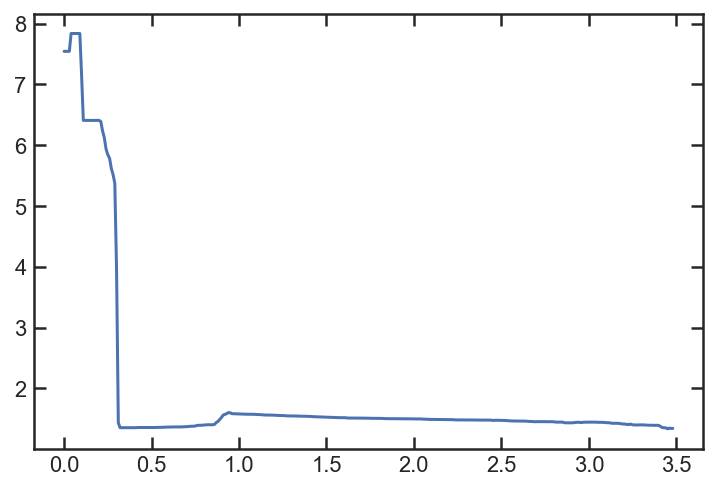

In [15]:
plt.plot(sfh.LBT, sfh.SFH)

# examine fits

In [2]:
Bdb = pd.read_pickle('../dataframes/fitdb/buldgefitsdb.pkl')

In [3]:
Bdb = Bdb.query('lwa > 0 and log_ssfr > -20')
Xdb = Bdb.query('AGN == "AGN"')
Qdb = Bdb.query('log_ssfr < -11 and AGN != "AGN"')
Sdb = Bdb.query('log_ssfr > -11 and AGN != "AGN"')
QXdb = Xdb.query('log_ssfr < -11')
SXdb = Xdb.query('log_ssfr > -11')

In [108]:
Bdb.query('log_ssfr > -11 and lwa > 1.5')[['field','id']]

,field,id
37,GSD,36482
83,GSD,45994
84,GND,11279
85,GND,11460
86,GND,12979
89,GND,14190
95,GND,18558
101,GND,23302
104,GND,25773
117,GND,35710


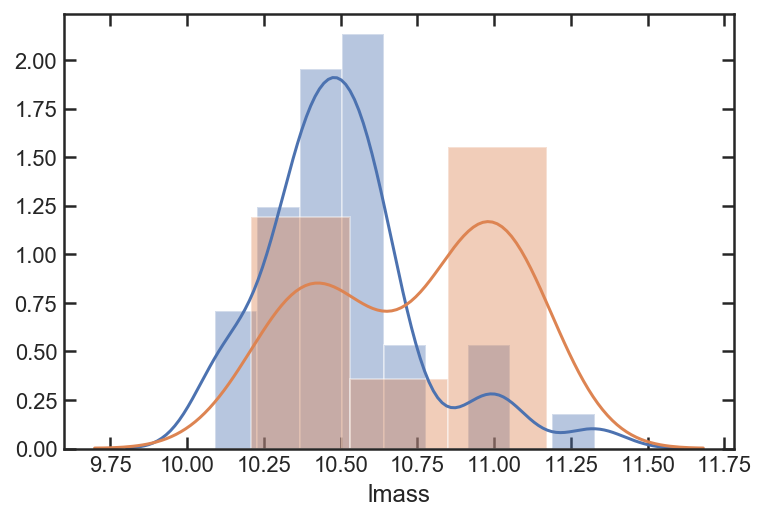

In [112]:
# sea.distplot(Bdb.lmass)
sea.distplot(Sdb.lmass)
sea.distplot(SXdb.lmass)

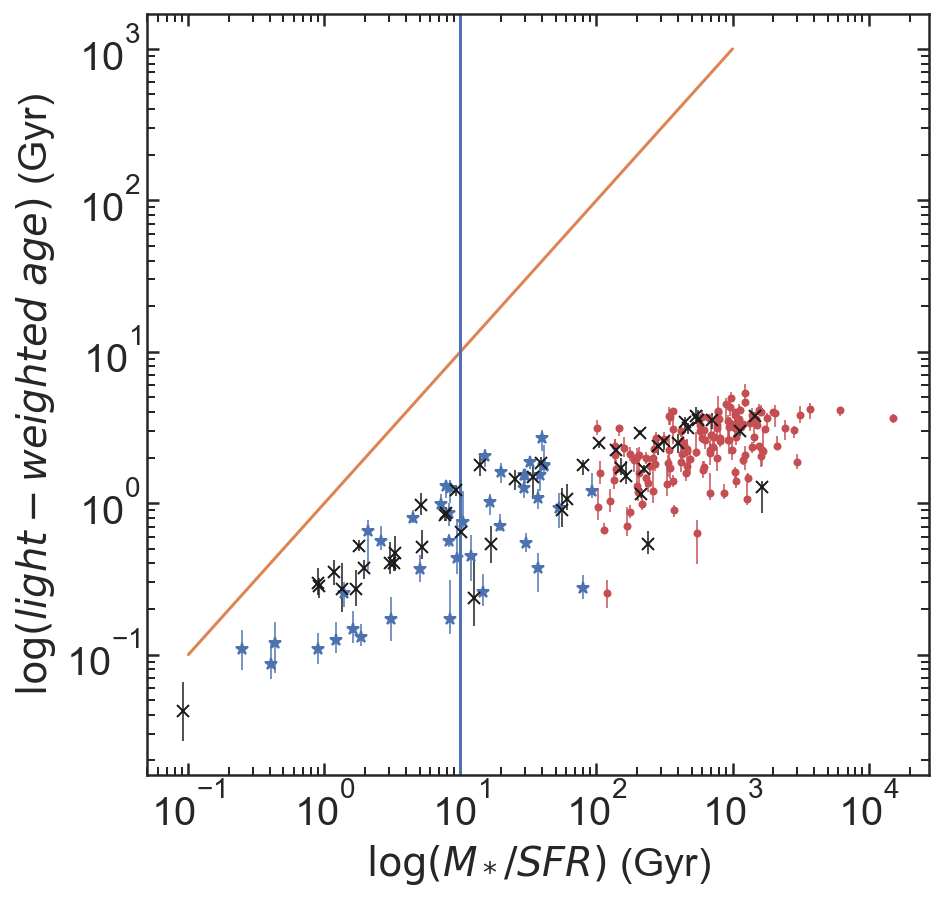

In [66]:
plt.figure(figsize = [7,7])

Qlerr = [U[0] for U in Qdb.lwa_hci.values ]
Slerr = [U[0] for U in Sdb.lwa_hci.values ]
Xlerr = [U[0] for U in Xdb.lwa_hci.values ]
Qherr = [U[1] for U in Qdb.lwa_hci.values ]
Sherr = [U[1] for U in Sdb.lwa_hci.values ]
Xherr = [U[1] for U in Xdb.lwa_hci.values ]


plt.errorbar(10**(-9-Qdb.log_ssfr), Qdb.lwa, yerr = [Qdb.lwa - Qlerr, Qherr - Qdb.lwa ], marker = 'o', color = 'r',linestyle = 'none', ms = 3, elinewidth=0.75)
plt.errorbar(10**(-9-Sdb.log_ssfr), Sdb.lwa, yerr = [Sdb.lwa - Slerr, Sherr - Sdb.lwa], marker = '*',linestyle = 'none', elinewidth=0.75 )
plt.errorbar(10**(-9-Xdb.log_ssfr), Xdb.lwa, yerr = [Xdb.lwa - Xlerr, Xherr - Xdb.lwa], marker = 'x', color = 'k',linestyle = 'none', elinewidth=0.75)
plt.plot([0.1,1000],[0.1,1000])

plt.yscale('log')
plt.xscale('log')

plt.axvline(10)
plt.xlabel('$\log(M_* / SFR)$ (Gyr)', fontsize = 20)
plt.ylabel('$\log(light-weighted \; age)$ (Gyr)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/lwa_vs_inv_ssfr.png', bbox_inches = 'tight')

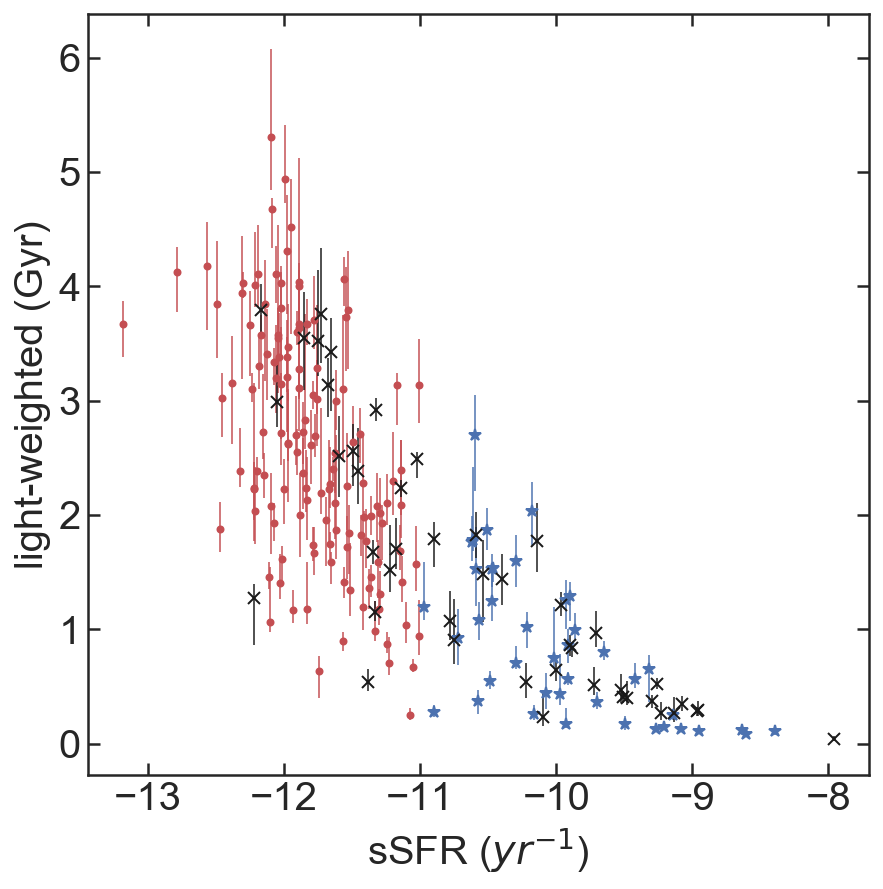

In [65]:
plt.figure(figsize = [7,7])

Qlerr = [U[0] for U in Qdb.lwa_hci.values ]
Slerr = [U[0] for U in Sdb.lwa_hci.values ]
Xlerr = [U[0] for U in Xdb.lwa_hci.values ]
Qherr = [U[1] for U in Qdb.lwa_hci.values ]
Sherr = [U[1] for U in Sdb.lwa_hci.values ]
Xherr = [U[1] for U in Xdb.lwa_hci.values ]


plt.errorbar(Qdb.log_ssfr, Qdb.lwa, yerr = [Qdb.lwa - Qlerr, Qherr - Qdb.lwa ], marker = 'o', color = 'r',linestyle = 'none', ms = 3, elinewidth=0.75)
plt.errorbar(Sdb.log_ssfr, Sdb.lwa, yerr = [Sdb.lwa - Slerr, Sherr - Sdb.lwa], marker = '*',linestyle = 'none' , elinewidth=0.75)
plt.errorbar(Xdb.log_ssfr, Xdb.lwa, yerr = [Xdb.lwa - Xlerr, Xherr - Xdb.lwa], marker = 'x', color = 'k',linestyle = 'none', elinewidth=0.75)

plt.xlabel('sSFR ($yr^{-1}$)', fontsize = 20)
plt.ylabel('light-weighted (Gyr)', fontsize = 20)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/lwa_vs_inv_ssfr.png', bbox_inches = 'tight')

(10.7, 9)

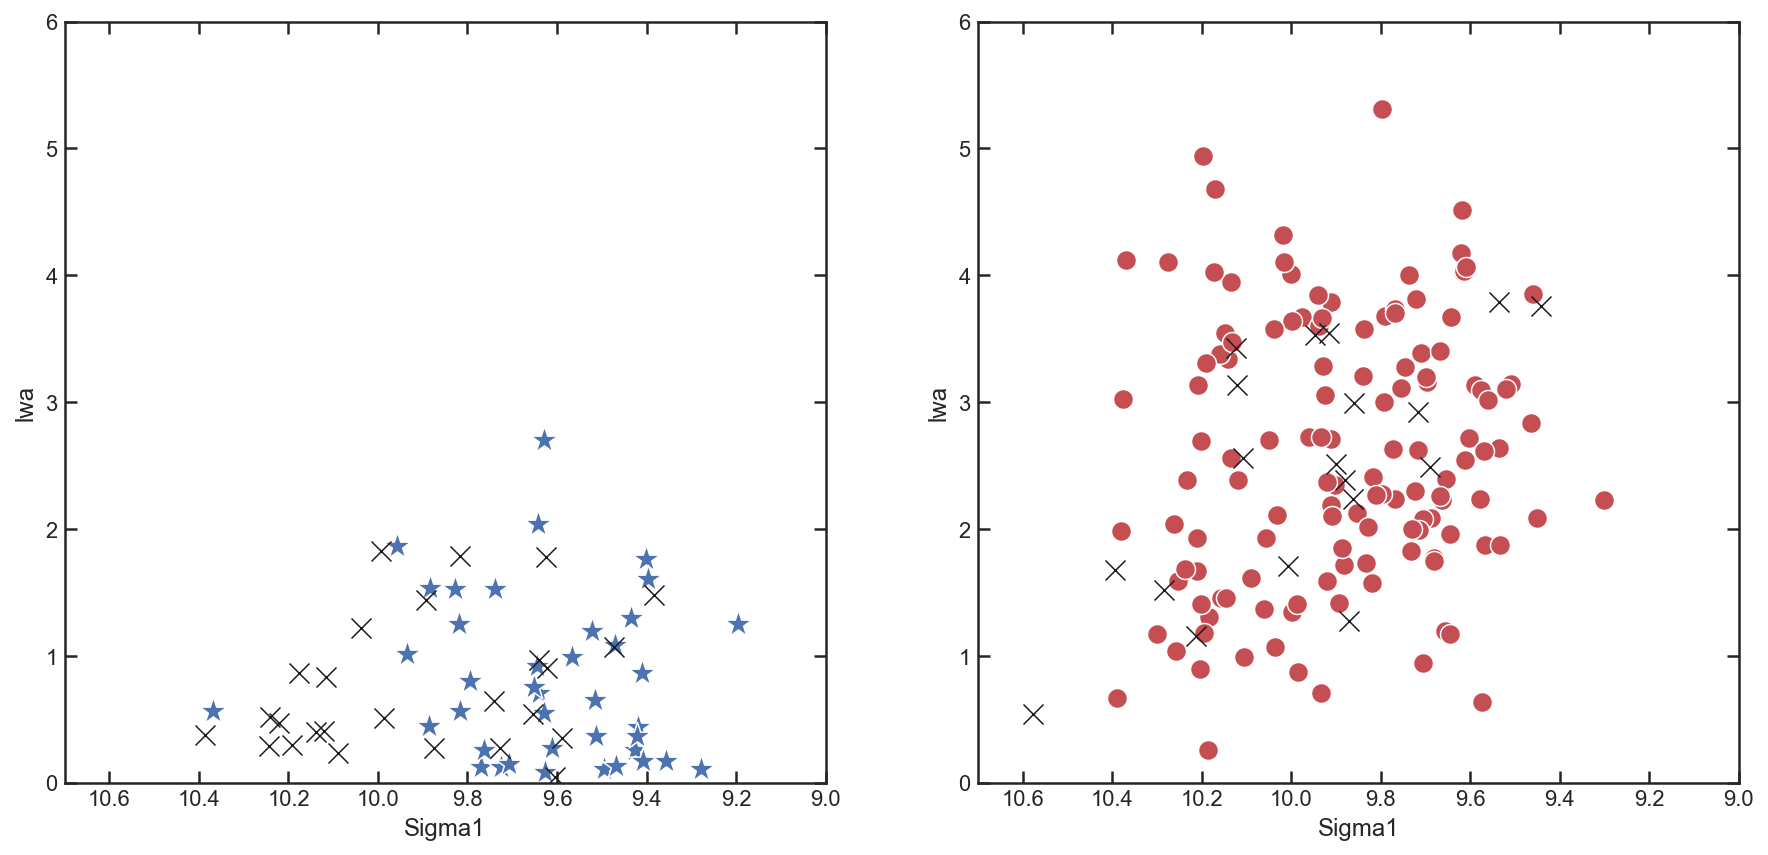

In [51]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [15,7])
ax1 = plt.subplot(gs[0])
sea.scatterplot(np.log10(Sdb.Sigma1), Sdb.lwa, marker = '*', s = 200, ax = ax1)
sea.scatterplot(np.log10(SXdb.Sigma1), SXdb.lwa, marker = 'x', s = 100, color = 'k', ax = ax1)
plt.ylim(0,6)
plt.xlim(10.7,9)

ax2 = plt.subplot(gs[1])
sea.scatterplot(np.log10(Qdb.Sigma1), Qdb.lwa, s = 100, color = 'r', ax = ax2)
sea.scatterplot(np.log10(QXdb.Sigma1), QXdb.lwa, marker = 'x', s = 100, color = 'k', ax = ax2)
plt.ylim(0,6)
plt.xlim(10.7,9)

(0.2, 4)

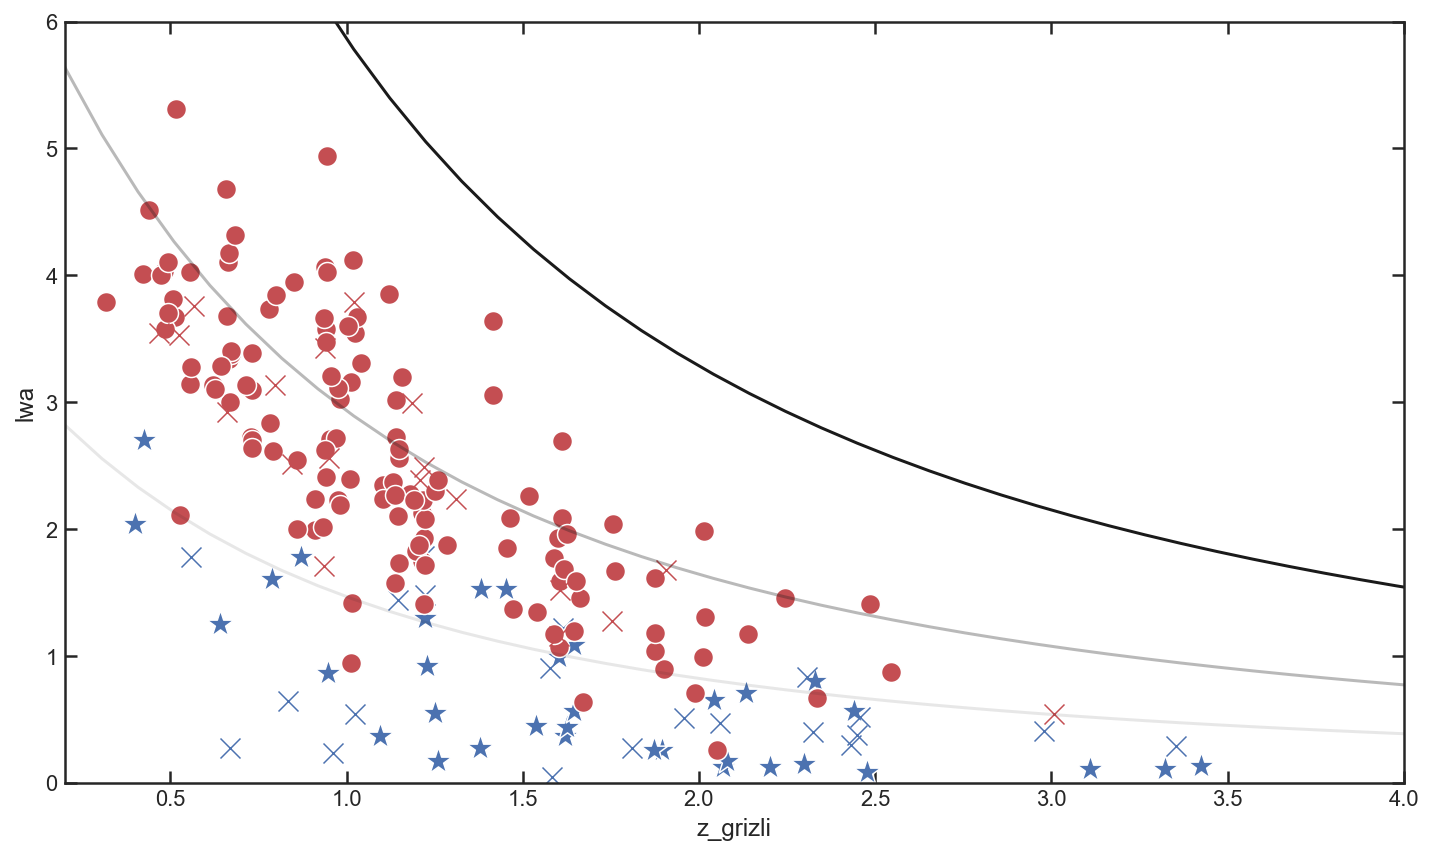

In [93]:
plt.figure(figsize = [12,7])
ax1 = plt.subplot()
sea.scatterplot(Sdb.z_grizli, Sdb.lwa, marker = '*', s = 200, ax = ax1)
sea.scatterplot(SXdb.z_grizli, SXdb.lwa, marker = 'x', s = 100, color = 'b', ax = ax1)
plt.ylim(0,6)
plt.xlim(0.2,4)

# ax2 = plt.subplot(gs[1])
sea.scatterplot(Qdb.zgrism, Qdb.lwa, color = 'r', s=100, ax = ax1,)
sea.scatterplot(QXdb.zgrism, QXdb.lwa, marker = 'x', s = 100, color = 'r', ax = ax1, )
sea.scatterplot(Qdb.z_grizli, Qdb.lwa, s = 100, color = 'r', ax = ax1,)
sea.scatterplot(QXdb.z_grizli, QXdb.lwa, marker = 'x', s = 100, color = 'r', ax = ax1,)

plt.plot(np.linspace(0,5), cosmo.age(np.linspace(0,5)), 'k', alpha = 1.0)
plt.plot(np.linspace(0,5), cosmo.age(np.linspace(0,5))/2, 'k', alpha = 0.3)
plt.plot(np.linspace(0,5), cosmo.age(np.linspace(0,5))/4, 'k', alpha = 0.1)

plt.ylim(0,6)
plt.xlim(0.2,4)


(0, 6)

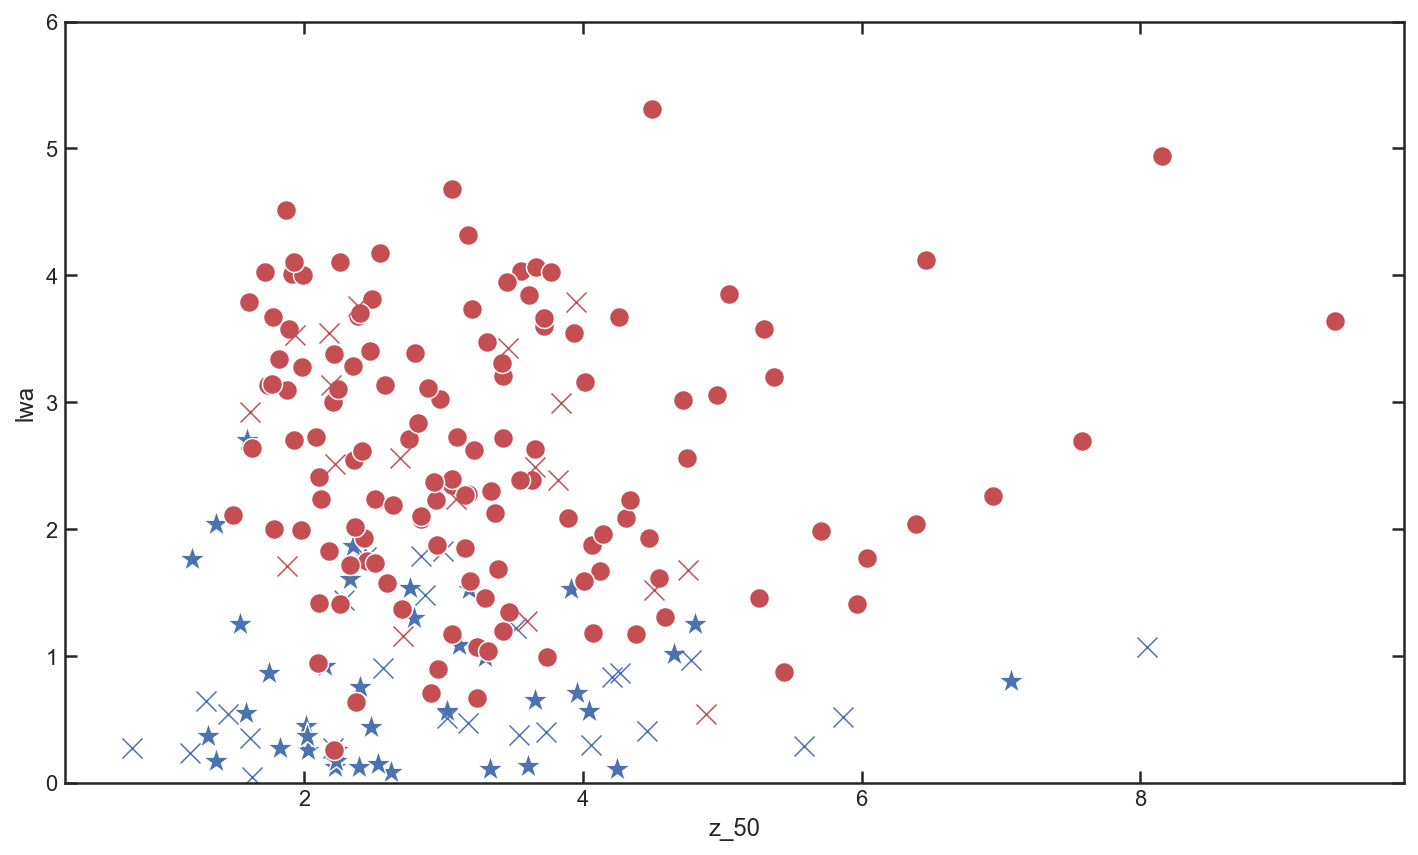

In [67]:
plt.figure(figsize = [12,7])
ax1 = plt.subplot()
sea.scatterplot(Sdb.z_50, Sdb.lwa, marker = '*', s = 200, ax = ax1)
sea.scatterplot(SXdb.z_50, SXdb.lwa, marker = 'x', s = 100, color = 'b', ax = ax1)
plt.ylim(0,6)
# plt.xlim(0.2,4)

# ax2 = plt.subplot(gs[1])
sea.scatterplot(Qdb.z_50, Qdb.lwa, s = 100, color = 'r', ax = ax1)
sea.scatterplot(QXdb.z_50, QXdb.lwa, marker = 'x', s = 100, color = 'r', ax = ax1)
plt.ylim(0,6)
# plt.xlim(0.2,4)

(0.2, 4)

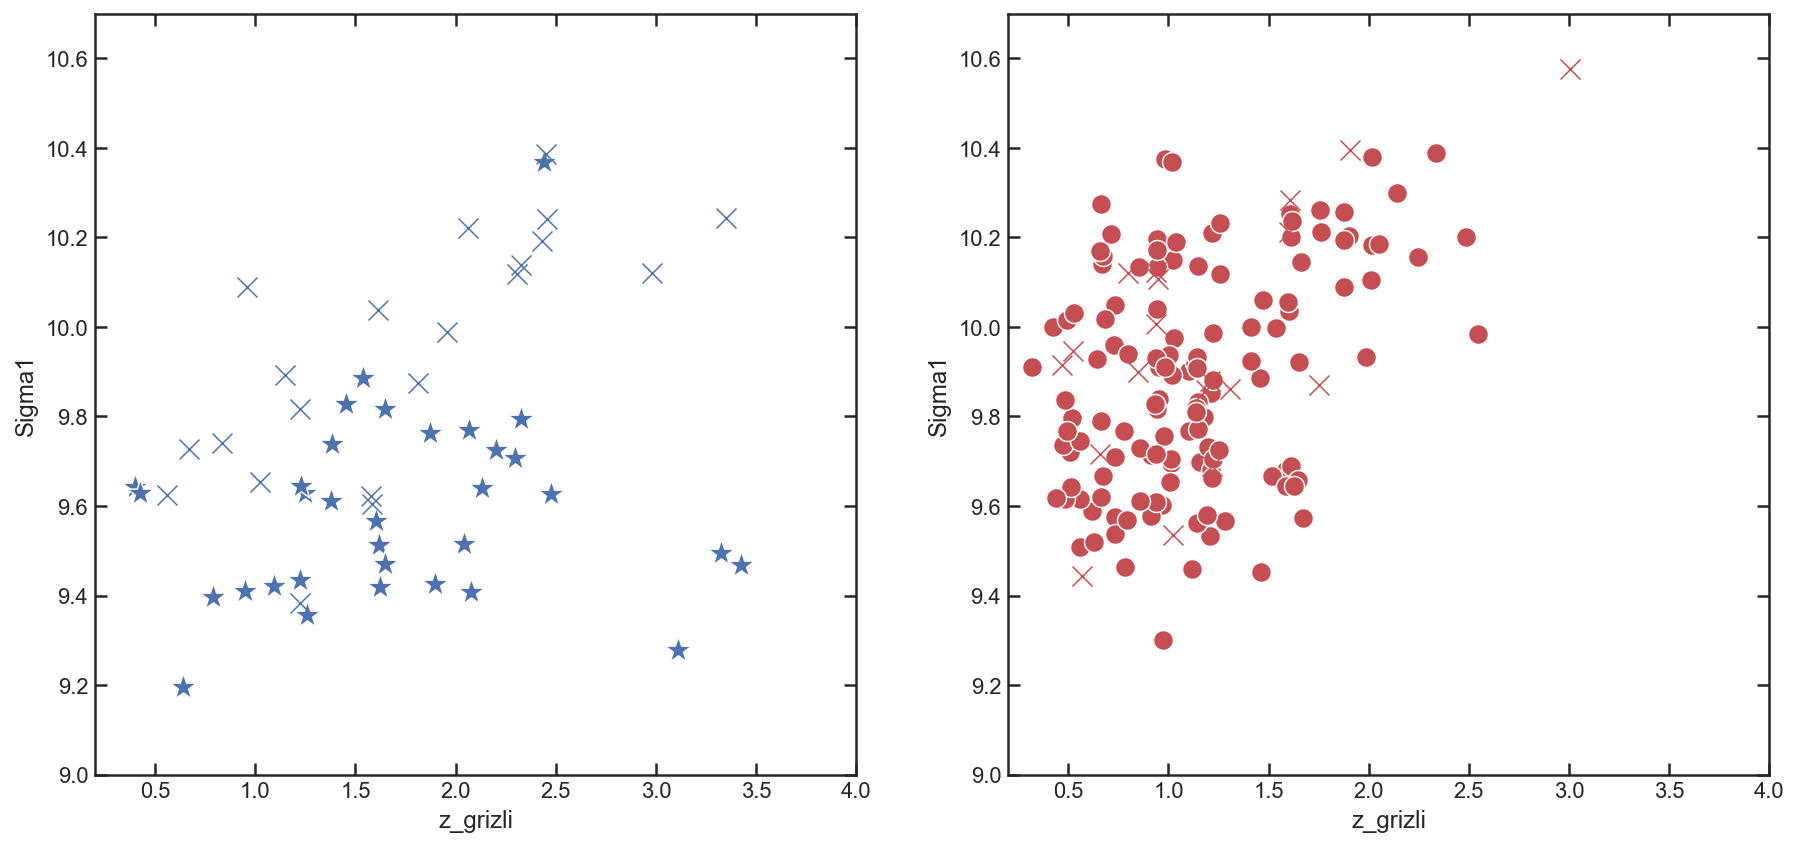

In [101]:
gs = gridspec.GridSpec(1,2)
plt.figure(figsize = [15,7])
ax1 = plt.subplot(gs[0])
sea.scatterplot(Sdb.z_grizli, np.log10(Sdb.Sigma1), marker = '*', s = 200, ax = ax1)
sea.scatterplot(SXdb.z_grizli, np.log10(SXdb.Sigma1), marker = 'x', s = 100, color = 'b', ax = ax1)
plt.ylim(9.0,10.7)
plt.xlim(0.2,4)

ax2 = plt.subplot(gs[1])
sea.scatterplot(Qdb.zgrism, np.log10(Qdb.Sigma1), color = 'r', s=100, ax = ax2)
sea.scatterplot(QXdb.zgrism, np.log10(QXdb.Sigma1), marker = 'x', s = 100, color = 'r', ax = ax2 )
sea.scatterplot(Qdb.z_grizli, np.log10(Qdb.Sigma1), s = 100, color = 'r', ax = ax2)
sea.scatterplot(QXdb.z_grizli, np.log10(QXdb.Sigma1), marker = 'x', s = 100, color = 'r', ax = ax2)


plt.ylim(9.0,10.7)
plt.xlim(0.2,4)


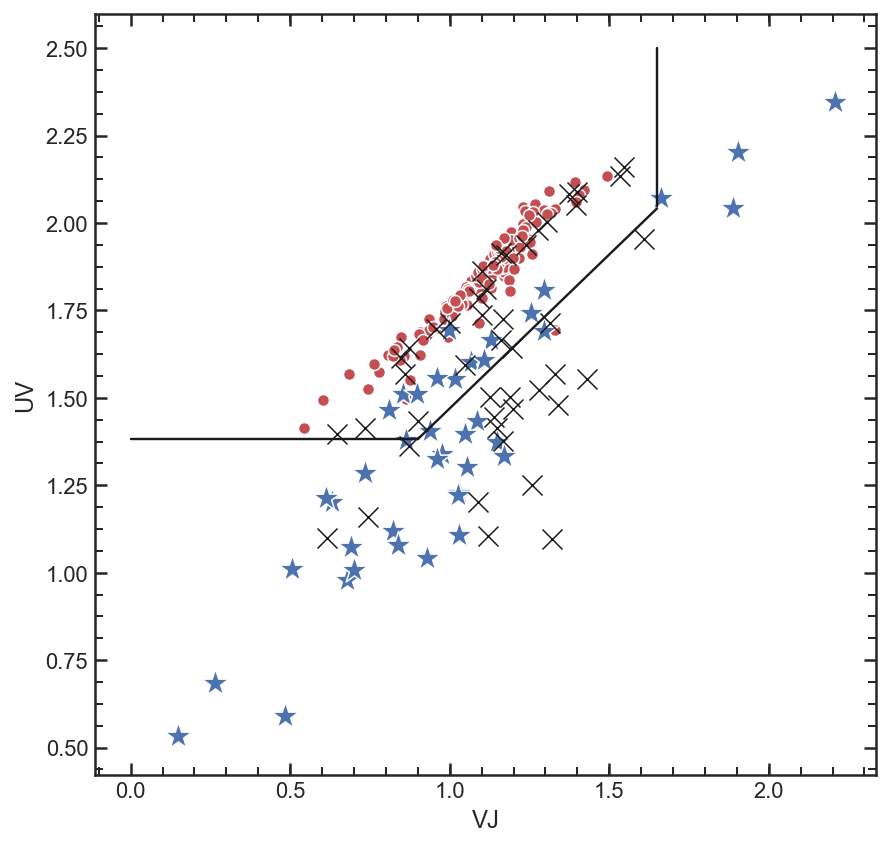

In [5]:
plt.figure(figsize = [7,7])
sea.scatterplot(Qdb.VJ, Qdb.UV, color = 'r')
sea.scatterplot(Sdb.VJ, Sdb.UV, marker = '*', s = 200)
sea.scatterplot(Xdb.VJ, Xdb.UV, marker = 'x', s = 100, color = 'k')
# plt.yscale('log')
plt.plot([0,.9],[1.382,1.382],'k',lw=1.2)
plt.plot([1.65,1.65],[2.05,2.5],'k',lw=1.2)
plt.plot([.9,1.65],[0.88*.9+0.59,0.88*1.65+0.59],'k',lw=1.2)